<a href="https://colab.research.google.com/github/emirbaki/ColabZamazingolarim/blob/main/Bitirme_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kütüphane kurulumları


In [1]:
!pip install pandas scikit-learn seaborn matplotlib ipympl tensorflow keras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.7/515.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.7 MB/s eta 0:00:00


## Layout Modelini Dataframe'e dökmek için bir script

In [2]:
import os
os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"


In [3]:
import pandas as pd
import numpy as np
import math

# --- Ayarlar ve Varsayımlar ---
KAT_SAYISI = 5
MAX_HACIM_M3 = 1.0  # Metreküp cinsinden - Değiştirilebilir
MAX_AGIRLIK_KG = 1000.0 # Kg cinsinden - Değiştirilebilir
RAF_DERINLIGI_M = 1.0 # Her bir raf sırasının derinliği
KORIDOR_ARASI_BOSLUK_M = 2.0 # Koridorlar arası yürüme/forklift yolu genişliği

# Koridor bilgileri: (Koridor No, Kattaki Toplam Adres, Hesaplanan Yatay Raf Sayısı/Sıra)
koridor_bilgileri = [
    (1, 54, 6),  # 54/5 = ~11 -> 6 raf/sıra
    (2, 108, 11), # 108/5 = ~22 -> 11 raf/sıra
    (3, 108, 11),
    (4, 108, 11),
    (5, 117, 12), # 117/5 = ~24 -> 12 raf/sıra
    (6, 126, 13)  # 126/5 = ~26 -> 13 raf/sıra
]

# Sevkiyat Alanı Merkez Koordinatları (Tahmini - Layout'a göre ayarlanabilir)
# En geniş koridor (13) bittikten sonra X=16 diyelim.
# Y ekseninde koridor 3 ve 4'ün ortasına yakın bir yer.
# Y hesaplaması: Koridor 1 (2m raf) + Aisle (2m) + Koridor 2 (2m) + Aisle (2m) + Koridor 3 (2m) + Aisle (2m)/2 = 11
SEVKIYAT_MERKEZI_X = 16
SEVKIYAT_MERKEZI_Y = 11 # Bu değeri layout'a göre daha sonra denemek için ayarlarım.
print(f"Tahmini Sevkiyat Alanı Merkezi: (X={SEVKIYAT_MERKEZI_X}, Y={SEVKIYAT_MERKEZI_Y})")

# --- Lokasyonları Oluşturma ---
lokasyonlar_listesi = []
mevcut_y = 0 # Başlangıç Y koordinatı

for koridor_no, _, yatay_raf_sayisi in koridor_bilgileri:
    print(f"Koridor {koridor_no} işleniyor (Genişlik: {yatay_raf_sayisi})...")
    # Koridorun başlangıç Y'si mevcut Y + boşluk (ilk koridor hariç)
    if koridor_no > 1:
        mevcut_y += KORIDOR_ARASI_BOSLUK_M

    # Koridorun iki sırasını işle
    for sira_no in [1, 2]: # 1: Ön sıra (Y düşük), 2: Arka sıra (Y yüksek)
        y_koordinati = mevcut_y + (sira_no - 1) * RAF_DERINLIGI_M + RAF_DERINLIGI_M / 2 # Rafın merkez Y'si

        for kolon_no in range(1, yatay_raf_sayisi + 1):
            x_koordinati = kolon_no - RAF_DERINLIGI_M / 2 # Rafın merkez X'si

            for kat_no in range(1, KAT_SAYISI + 1):
                z_koordinati = kat_no # Kat numarası Z olarak kullanılabilir

                # Lokasyon ID Oluşturma (Örn: C1-S1-K5-L3)
                lokasyon_id = f"C{koridor_no}-S{sira_no}-K{kolon_no}-L{kat_no}"

                # Raf Tipi Belirleme
                if kat_no == 1:
                    raf_tipi = 'Zemin'
                elif kat_no == KAT_SAYISI:
                    raf_tipi = 'Ust'
                else:
                    raf_tipi = 'Orta'

                # Sevkiyat Alanına Uzaklık Hesaplama (Öklid)
                uzaklik = math.sqrt(
                    (x_koordinati - SEVKIYAT_MERKEZI_X)**2 +
                    (y_koordinati - SEVKIYAT_MERKEZI_Y)**2
                )

                lokasyon_data = {
                    'LokasyonID': lokasyon_id,
                    'Koridor': koridor_no,
                    'Sira': sira_no, # Koridor içindeki sıra (1 veya 2)
                    'Kolon': kolon_no, # Koridor boyunca raf sırası
                    'Kat': kat_no,
                    'X_Koordinati': round(x_koordinati, 2),
                    'Y_Koordinati': round(y_koordinati, 2),
                    'Z_Koordinati': z_koordinati,
                    'Tip': raf_tipi,
                    'Max_Hacim': MAX_HACIM_M3,
                    'Max_Agirlik': MAX_AGIRLIK_KG,
                    'Sevkiyat_Uzakligi': round(uzaklik, 2),
                    'Dolu_Mu': False # Başlangıçta tüm raflar boş
                }
                lokasyonlar_listesi.append(lokasyon_data)

    # Sonraki koridor için Y koordinatını güncelle (2 sıra raf derinliği ekle)
    mevcut_y += 2 * RAF_DERINLIGI_M

# --- DataFrame Oluşturma ve Kaydetme ---
df_layout = pd.DataFrame(lokasyonlar_listesi)

print("\n--- Oluşturulan Layout Verisi (İlk 10 Satır) ---")
print(df_layout.head(10))

print("\n--- Layout Verisi Bilgileri ---")
print(df_layout.info())

print(f"\nToplam {len(df_layout)} lokasyon oluşturuldu.")

# Excel dosyasına kaydetme
try:
    output_filename = 'depo_layout.xlsx'
    df_layout.to_excel(output_filename, index=False)
    print(f"\nLayout başarıyla '{output_filename}' dosyasına kaydedildi.")
except Exception as e:
    print(f"\nHata: Excel dosyasına yazılırken sorun oluştu - {e}")

Tahmini Sevkiyat Alanı Merkezi: (X=16, Y=11)
Koridor 1 işleniyor (Genişlik: 6)...
Koridor 2 işleniyor (Genişlik: 11)...
Koridor 3 işleniyor (Genişlik: 11)...
Koridor 4 işleniyor (Genişlik: 11)...
Koridor 5 işleniyor (Genişlik: 12)...
Koridor 6 işleniyor (Genişlik: 13)...

--- Oluşturulan Layout Verisi (İlk 10 Satır) ---
    LokasyonID  Koridor  Sira  Kolon  Kat  X_Koordinati  Y_Koordinati  \
0  C1-S1-K1-L1        1     1      1    1           0.5           0.5   
1  C1-S1-K1-L2        1     1      1    2           0.5           0.5   
2  C1-S1-K1-L3        1     1      1    3           0.5           0.5   
3  C1-S1-K1-L4        1     1      1    4           0.5           0.5   
4  C1-S1-K1-L5        1     1      1    5           0.5           0.5   
5  C1-S1-K2-L1        1     1      2    1           1.5           0.5   
6  C1-S1-K2-L2        1     1      2    2           1.5           0.5   
7  C1-S1-K2-L3        1     1      2    3           1.5           0.5   
8  C1-S1-K2-L4       

## Modele başlamadan önce veri işleme

In [4]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import math # Hacim hesabı için gerekebilir

# --- 1. Veri Yükleme ---
try:
    # sevkiyat logları
    df_hareket = pd.read_excel("/content/urun_ozellikleri.xlsx", sheet_name= "Stok Hareketleri")

    # ürün logları
    df_ozellik = pd.read_excel("/content/urun_ozellikleri.xlsx", sheet_name= "Ürün Ana verisi")

    df_ozellik["Height"] = df_ozellik["Height"].str.replace(",", ".")
    df_ozellik["Height"] = pd.to_numeric(df_ozellik["Height"], errors="coerce")
    df_ozellik["Width"] = df_ozellik["Width"].str.replace(",", ".")
    df_ozellik["Width"] = pd.to_numeric(df_ozellik["Width"], errors="coerce")
    df_ozellik["Length"] = df_ozellik["Length"].str.replace(",", ".")
    df_ozellik["Length"] = pd.to_numeric(df_ozellik["Length"], errors="coerce")
    # df_layout = pd.read_excel('depo_layout.xlsx')
    print("Excel dosyaları başarıyla yüklendi.")
except FileNotFoundError as e:
    print(f"Hata: Dosya bulunamadı - {e}. Dosya yollarını kontrol edin.")
    exit()
except Exception as e:
    print(f"Excel dosyaları okunurken bir hata oluştu: {e}")
    exit()

# --- 2. Veri Ön İşleme ve Zenginleştirme ---

# Gerekli sütunların varlığını kontrol edelim (varsayılan isimler)
required_hareket_cols = ['SKU', 'Movement'] # 'Tarih' ve 'Miktar' da sıklık için lazım olabilir
required_ozellik_cols = ['SKU', 'Net_Weight', 'Width', 'Length', 'Height'] # Kategori vb. de olabilir
required_layout_cols = ['LokasyonID', 'Sevkiyat_Uzakligi', 'Max_Agirlik', 'Max_Hacim', 'Dolu_Mu'] # 'Dolu_Mu' ekledim en son

# Basit kontrol (daha detaylı yapılabilir)
if not all(col in df_hareket.columns for col in ['SKU', 'Movement']):
    print("Hata: 'urun_hareketleri.xlsx' dosyasında gerekli 'Ürün Kodu' veya 'Depo Hareketi' sütunları eksik.")
    exit()
if not all(col in df_ozellik.columns for col in required_ozellik_cols):
    print(f"Hata: 'urun_ozellikleri.xlsx' dosyasında gerekli sütunlar eksik ({required_ozellik_cols}).")
    exit()
if not all(col in df_layout.columns for col in required_layout_cols):
     print(f"Hata: 'depo_layout.xlsx' dosyasında gerekli sütunlar eksik ({required_layout_cols}).")
     # 'Dolu_Mu' sütunu yoksa oluşturalım (Başlangıçta hepsi boş)
     if 'Dolu_Mu' not in df_layout.columns:
         print("'Dolu_Mu' sütunu layout dosyasında bulunamadı, başlangıçta tüm lokasyonlar boş varsayılıyor.")
         df_layout['Dolu_Mu'] = False
     else: # Varsa ve eksikse çıkış yapalım
        print(f"Hata: 'depo_layout.xlsx' dosyasında gerekli sütunlar eksik ({required_layout_cols}).")
        exit()


# a) Sevkiyat Sıklığı Hesaplama (Örnek: Son N gündeki çıkış sayısı)
# df_hareket['Tarih'] = pd.to_datetime(df_hareket['Tarih']) # Tarih sütunu varsa
# son_tarih = df_hareket['Tarih'].max()
# baslangic_tarih = son_tarih - pd.Timedelta(days=90) # Son 90 gün
# sevkiyatlar = df_hareket[(df_hareket['Tip'] == 'Sevkiyat') & (df_hareket['Tarih'] >= baslangic_tarih)]

# Basit versiyon: Toplam 'Sevkiyat' kaydı sayısı
sevkiyatlar = df_hareket[df_hareket['Movement'].str.contains('Sevkiyat|Çıkış|Dış', case=False, na=False)] # Tip değerlerinize göre düzenleyin
sevkiyat_sikligi = sevkiyatlar['SKU'].value_counts().reset_index()
sevkiyat_sikligi.columns = ['SKU', 'Shipment_Frequency']

# b) Özellikler ile Birleştirme
df_urunler = pd.merge(df_ozellik, sevkiyat_sikligi, on='SKU', how='left')
df_urunler.fillna({'Shipment_Frequency' : 0}, inplace = True) # Sevkiyatı olmayan ürünler için 0

# c) Hacim Hesaplama (Varsa)
if all(col in df_urunler.columns for col in ['Width', 'Length', 'Height']):
    df_urunler['Volume'] = df_urunler['Width'] * df_urunler['Length'] * df_urunler['Height']
else:
    print("Uyarı: Hacim hesabı için 'En', 'Boy', 'Yükseklik' sütunları bulunamadı.")
    df_urunler['Volume'] = 1 # Hacim kısıtı yoksa veya hesaplanamıyorsa varsayılan değer

# d) Eksik Veri Yönetimi (Örnek: Ağırlık için ortalama)
df_urunler.fillna({'Net_Weight' : df_urunler['Net_Weight'].median()}, inplace=True)
# Diğer eksik veriler için de benzer stratejiler uygulanabilir

print("\n--- Veri Ön İşleme Tamamlandı ---")
print(df_urunler.head())



Excel dosyaları başarıyla yüklendi.

--- Veri Ön İşleme Tamamlandı ---
       SKU          Name Product_Group  Net_Weight  Gross_Weight  Width  \
0  R000001    Mama 57 gr          Mama          50          57.0    8.0   
1  R000002   Mama 513 gr          Mama         500         513.0    7.0   
2  R000003  Mama 1529 gr          Mama        1500        1529.0   12.0   
3  R000004  Mama 3040 gr          Mama        3000        3040.0   14.0   
4  R000005    Mama 55 gr          Mama          50          55.0    8.0   

   Length  Height  Palet_Standard  Shipment_Frequency    Volume  
0   125.0   320.0            1920                 0.0  320000.0  
1    24.5    14.0             384                68.0    2401.0  
2    40.0    18.5             108              2039.0    8880.0  
3    49.0    24.5              72               640.0   16807.0  
4   125.0   320.0            1920                 0.0  320000.0  


In [5]:
df_urunler

,SKU,Name,Product_Group,Net_Weight,Gross_Weight,Width,Length,Height,Palet_Standard,Shipment_Frequency,Volume
0,R000001,Mama 57 gr,Mama,50,57.0,8.0,125.0,320.0,1920,0.0,320000.0
1,R000002,Mama 513 gr,Mama,500,513.0,7.0,24.5,14.0,384,68.0,2401.0
2,R000003,Mama 1529 gr,Mama,1500,1529.0,12.0,40.0,18.5,108,2039.0,8880.0
3,R000004,Mama 3040 gr,Mama,3000,3040.0,14.0,49.0,24.5,72,640.0,16807.0
4,R000005,Mama 55 gr,Mama,50,55.0,8.0,125.0,320.0,1920,0.0,320000.0
...,...,...,...,...,...,...,...,...,...,...,...
644,R000645,Aksesuar,Aksesuar,10,12.0,10.0,10.0,10.0,5000,27.0,1000.0
645,R000646,Aksesuar,Aksesuar,10,12.0,10.0,10.0,10.0,200,26.0,1000.0
646,R000647,Aksesuar,Aksesuar,10,12.0,10.0,10.0,10.0,100,21.0,1000.0
647,R000648,Aksesuar,Aksesuar,90000,92000.0,10.0,10.0,10.0,3,9.0,1000.0


## K-Means Elbow ve Genel Clustering

Creating dummy df_products_processed for demonstration...
Calculating WCSS for k from 1 to 30...
  WCSS for k=1: 25.82
  WCSS for k=2: 18.91
  WCSS for k=3: 14.43
  WCSS for k=4: 11.13
  WCSS for k=5: 9.08
  WCSS for k=6: 7.76
  WCSS for k=7: 6.60
  WCSS for k=8: 5.73
  WCSS for k=9: 5.12
  WCSS for k=10: 4.65
  WCSS for k=11: 4.36
  WCSS for k=12: 3.97
  WCSS for k=13: 3.77
  WCSS for k=14: 3.56
  WCSS for k=15: 3.29
  WCSS for k=16: 3.05
  WCSS for k=17: 2.82
  WCSS for k=18: 2.69
  WCSS for k=19: 2.35
  WCSS for k=20: 2.28
  WCSS for k=21: 2.23
  WCSS for k=22: 2.05
  WCSS for k=23: 1.96
  WCSS for k=24: 1.91
  WCSS for k=25: 1.78
  WCSS for k=26: 1.72
  WCSS for k=27: 1.61
  WCSS for k=28: 1.54
  WCSS for k=29: 1.45
  WCSS for k=30: 1.38


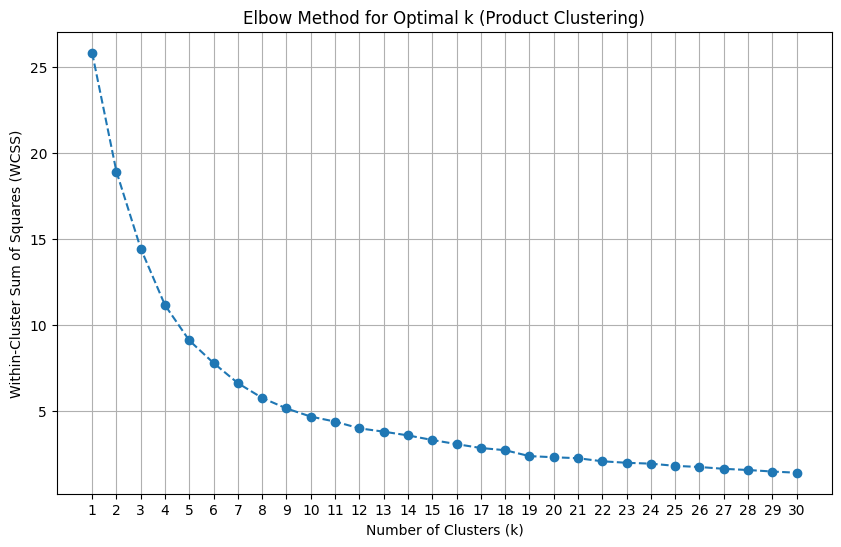


Elbow method plot generated as 'kmeans_elbow_plot.png'.
Look for the 'elbow' point in the plot to determine a suitable k.
This is the point where adding more clusters provides diminishing returns in reducing WCSS.

Assuming optimal k = 13 based on the plot.

Cluster labels assigned with optimal k (example):
     Weight    Volume  ShippingFrequency  ClusterID_KMeans
0  0.497614  0.060913           0.112821                 9
1  0.642237  0.499726           0.046154                 2
2  0.091435  0.347508           0.820513                10
3  0.318871  0.707412           0.271795                 4
4  0.750832  0.120420           0.061538                 9


In [6]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler # Assuming you used this for scaling
import matplotlib.pyplot as plt
import joblib # If you saved your scaler

# --- Load or Recreate your Processed Product Data ---
# This is crucial: use the SAME scaled data that your TTM will eventually see
# For this example, let's assume df_products_processed is already loaded
# and contains scaled numerical features.

# If you need to reload and reprocess (simplified example):
# try:
#     df_products_raw = pd.read_excel('urun_ozellikleri.xlsx')
#     # Assuming 'Volume' is calculated, 'ShippingFrequency' exists
#     # If 'Volume' is not in PRODUCT_NUMERICAL_COLS originally:
#     if 'Volume' not in PRODUCT_NUMERICAL_COLS: PRODUCT_NUMERICAL_COLS.append('Volume')
#     df_products_raw['Volume'] = df_products_raw.get('Length',1) * df_products_raw.get('Width',1) * df_products_raw.get('Height',1)

#     product_numerical_features_for_clustering = df_products_raw[PRODUCT_NUMERICAL_COLS].copy()
#     # Fill NaNs before scaling if any
#     product_numerical_features_for_clustering.fillna(product_numerical_features_for_clustering.median(), inplace=True)


#     # Load your fitted scaler OR fit a new one JUST for this clustering exercise
#     # It's best to use the SAME scaler object if this clustering is part of the main pipeline
#     try:
#         product_scaler_clustering = joblib.load(PRODUCT_SCALER_FILE) # Your saved scaler
#         product_num_scaled_clustering = product_scaler_clustering.transform(product_numerical_features_for_clustering)
#     except FileNotFoundError:
#         print("Product scaler not found, fitting a new one for clustering demonstration.")
#         product_scaler_clustering = MinMaxScaler()
#         product_num_scaled_clustering = product_scaler_clustering.fit_transform(product_numerical_features_for_clustering)

#     df_products_for_clustering = pd.DataFrame(product_num_scaled_clustering, columns=PRODUCT_NUMERICAL_COLS)
#     print("Data for clustering prepared.")
# except Exception as e:
#     print(f"Error preparing data for clustering: {e}")
#     exit()

# FOR THIS EXAMPLE, LET'S ASSUME `df_products_processed` already exists
# and `features_for_kmeans` lists the SCALED numerical columns you want to use.

# --- Example: Assuming df_products_processed from your TTM code is available ---
# And PRODUCT_NUMERICAL_COLS are the ones you want to use (they are already scaled in df_products_processed)
# Example:
# PRODUCT_NUMERICAL_COLS = ['Weight', 'Volume', 'ShippingFrequency'] (already scaled in df_products_processed)
# df_products_processed would have these scaled columns.

# Make sure df_products_processed and relevant columns are defined from your TTM script
# For safety, let's re-create a sample df_products_processed for this standalone example
# In your actual project, you'd use your existing df_products_processed
if 'df_products_processed' not in locals():
    print("Creating dummy df_products_processed for demonstration...")
    data_dummy = {
        'Weight': np.random.rand(100) * 100,
        'Volume': np.random.rand(100) * 0.5,
        'ShippingFrequency': np.random.randint(1, 200, 100)
    }
    df_products_dummy_raw = pd.DataFrame(data_dummy)
    scaler_dummy = MinMaxScaler()
    scaled_dummy_data = scaler_dummy.fit_transform(df_products_dummy_raw)
    df_products_processed = pd.DataFrame(scaled_dummy_data, columns=['Weight', 'Volume', 'ShippingFrequency'])
    PRODUCT_NUMERICAL_COLS_FOR_CLUSTERING = ['Weight', 'Volume', 'ShippingFrequency']
else:
    # Define which columns from your existing df_products_processed to use
    # Ensure these are the SCALED numerical columns
    PRODUCT_NUMERICAL_COLS_FOR_CLUSTERING = ['Weight', 'Volume', 'ShippingFrequency'] # Adjust as needed
    # Verify columns exist
    if not all(col in df_products_processed.columns for col in PRODUCT_NUMERICAL_COLS_FOR_CLUSTERING):
        print(f"Error: Not all specified clustering columns found in df_products_processed.")
        print(f"Needed: {PRODUCT_NUMERICAL_COLS_FOR_CLUSTERING}")
        print(f"Available: {df_products_processed.columns.tolist()}")
        exit()


# --- 1. Select Features for Clustering ---
# Ensure these are the SCALED numerical features
X_clustering = df_products_processed[PRODUCT_NUMERICAL_COLS_FOR_CLUSTERING].values

# --- 2. Iterate through K values and Calculate WCSS ---
wcss = [] # Within-Cluster Sum of Squares
k_range = range(1, 31) # Test k from 1 to 10 (adjust range as needed)

print(f"Calculating WCSS for k from {k_range.start} to {k_range.stop-1}...")
for k_val in k_range:
    kmeans = KMeans(n_clusters=k_val,
                    init='k-means++',     # Smart initialization
                    n_init=20,            # Run K-Means 10 times with different centroids, pick best
                    max_iter=300,         # Max iterations for one run
                    random_state=42)      # For reproducibility
    kmeans.fit(X_clustering)
    wcss.append(kmeans.inertia_) # inertia_ is the WCSS value
    print(f"  WCSS for k={k_val}: {kmeans.inertia_:.2f}")

# --- 3. Plot WCSS vs. K ---
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k (Product Clustering)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(list(k_range)) # Ensure all k values are shown as ticks
plt.grid(True)
plt.savefig('kmeans_elbow_plot.png') # Save the plot
plt.show()

print("\nElbow method plot generated as 'kmeans_elbow_plot.png'.")
print("Look for the 'elbow' point in the plot to determine a suitable k.")
print("This is the point where adding more clusters provides diminishing returns in reducing WCSS.")

# --- 4. (Optional) Choose k and assign clusters (Example) ---
# Based on the plot, choose your optimal k. Let's say it's 3 for this example.
optimal_k = 13 # ** YOU NEED TO DETERMINE THIS FROM THE PLOT **
print(f"\nAssuming optimal k = {optimal_k} based on the plot.")

final_kmeans = KMeans(n_clusters=optimal_k,
                      init='k-means++',
                      n_init=20,
                      max_iter=300,
                      random_state=42)
cluster_labels = final_kmeans.fit_predict(X_clustering)

# Add cluster labels back to your original (or processed) DataFrame
# Make sure indices align if you took a subset for clustering
# If X_clustering came directly from df_products_processed's columns:
df_products_processed['ClusterID_KMeans'] = cluster_labels
print("\nCluster labels assigned with optimal k (example):")
print(df_products_processed[[*PRODUCT_NUMERICAL_COLS_FOR_CLUSTERING, 'ClusterID_KMeans']].head())

# You would then use these 'ClusterID_KMeans' (after appropriate encoding if needed)
# as input to your Two-Tower Model if 'ClusterID' is one of your PRODUCT_CATEGORICAL_COLS.

  Silhouette Score for k=2: 0.260
  Silhouette Score for k=3: 0.254
  Silhouette Score for k=4: 0.276
  Silhouette Score for k=5: 0.277
  Silhouette Score for k=6: 0.301
  Silhouette Score for k=7: 0.316
  Silhouette Score for k=8: 0.321
  Silhouette Score for k=9: 0.324
  Silhouette Score for k=10: 0.315
  Silhouette Score for k=11: 0.338
  Silhouette Score for k=12: 0.305
  Silhouette Score for k=13: 0.308
  Silhouette Score for k=14: 0.322
  Silhouette Score for k=15: 0.322
  Silhouette Score for k=16: 0.332
  Silhouette Score for k=17: 0.319
  Silhouette Score for k=18: 0.301
  Silhouette Score for k=19: 0.346
  Silhouette Score for k=20: 0.321
  Silhouette Score for k=21: 0.321
  Silhouette Score for k=22: 0.321
  Silhouette Score for k=23: 0.315
  Silhouette Score for k=24: 0.318
  Silhouette Score for k=25: 0.326
  Silhouette Score for k=26: 0.299
  Silhouette Score for k=27: 0.315
  Silhouette Score for k=28: 0.324
  Silhouette Score for k=29: 0.309
  Silhouette Score for k=30:

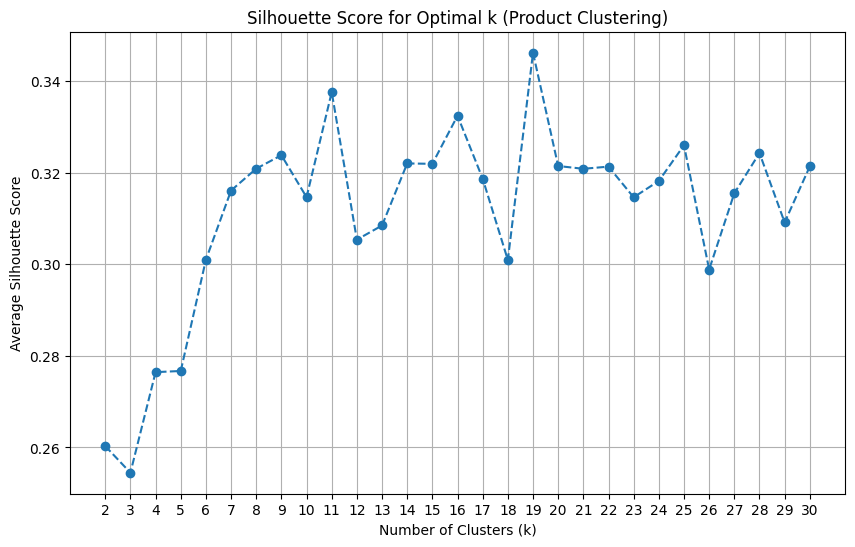

In [7]:
from sklearn.metrics import silhouette_score

silhouette_avg_scores = []
k_range = range(2, 31) # Silhouette score needs at least 2 clusters

for k_val in k_range:
    kmeans = KMeans(n_clusters=k_val, init='k-means++', n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(X_clustering) # X_clustering is your scaled features
    silhouette_avg = silhouette_score(X_clustering, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)
    print(f"  Silhouette Score for k={k_val}: {silhouette_avg:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_avg_scores, marker='o', linestyle='--')
plt.title('Silhouette Score for Optimal k (Product Clustering)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.xticks(list(k_range))
plt.grid(True)
plt.savefig('kmeans_silhouette_plot.png')
plt.show()

In [27]:
# --- 3. Ürün Kümeleme (Clustering) ---

# Kümeleme için kullanılacak özellikleri seçin (Ağırlık ve Sıklık HARİÇ olabilir)
# Örnek: Boyutlar veya Kategori (Kategori varsa one-hot encoding gerekebilir)
# Şimdilik basitlik adına sadece Hacim kullanalım (veya boyutlar)
# Eğer kategori gibi metinsel veriler varsa:
# df_urunler = pd.get_dummies(df_urunler, columns=['Kategori'])

features_for_clustering = ['Volume', 'Net_Weight', 'Shipment_Frequency'] # Veya ['En', 'Boy', 'Yükseklik']
if not all(f in df_urunler.columns for f in features_for_clustering):
     print(f"Hata: Kümeleme için gerekli özellikler bulunamadı: {features_for_clustering}")
     exit()

# Veriyi ölçeklendirme (K-Means gibi mesafe bazlı algoritmalar için önemli)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_urunler[features_for_clustering])

# K-Means Modelini Oluşturma ve Eğitme
# Küme sayısını (n_clusters) belirlemek gerekiyor. Elbow metodu ile bulunabilir.
optimal_k = 15
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10) # n_init uyarısını engeller
df_urunler['ClusterID'] = kmeans.fit_predict(scaled_features)

print(f"\n--- Kümeleme Tamamlandı ({optimal_k} küme) ---")
print(df_urunler[['SKU', 'ClusterID']].head())
print("\nKüme Boyutları:")
print(df_urunler['ClusterID'].value_counts())


df_urunler.to_excel('urun_ozellikleri_processed.xlsx', index=False)


--- Kümeleme Tamamlandı (15 küme) ---
       SKU  ClusterID
0  R000001          2
1  R000002         13
2  R000003          4
3  R000004          8
4  R000005          2

Küme Boyutları:
ClusterID
13    307
0      84
11     67
5      50
8      49
2      32
4      26
9       8
10      8
14      6
6       3
7       3
3       2
12      2
1       2
Name: count, dtype: int64


In [28]:
# Group by 'cluster_id' and apply aggregation functions
summary_statistics = df_urunler.groupby('ClusterID')[[ 'Net_Weight', 'Shipment_Frequency' , 'Length' , 'Width' , 'Height']].agg(['mean', 'std', 'min', 'max'])

# You can also get more detailed statistics using .describe() on grouped data
# for column_name in ['column1', 'column2']:
#     print(f"Summary for {column_name}:")
#     print(df.groupby('cluster_id')[column_name].describe())

print(summary_statistics)

             Net_Weight                              Shipment_Frequency  \
                   mean           std    min     max               mean   
ClusterID                                                                 
0           1394.083333   1182.644568      8    4000         340.083333   
1          60315.000000   3995.153314  57490   63140           0.000000   
2             50.000000      0.000000     50      50           3.406250   
3           3000.000000   1414.213562   2000    4000        6191.500000   
4           1880.961538   1387.269995     85    4000        1964.384615   
5          15545.400000   2010.455538  13000   20000         105.020000   
6           9000.000000   6557.438524   2000   15000        8612.333333   
7          93246.666667  12939.185961  82240  107500           3.000000   
8           2406.122449   1673.553874     85    7500         885.183673   
9          31028.750000   1958.975224  28000   34120           0.000000   
10          4646.250000  

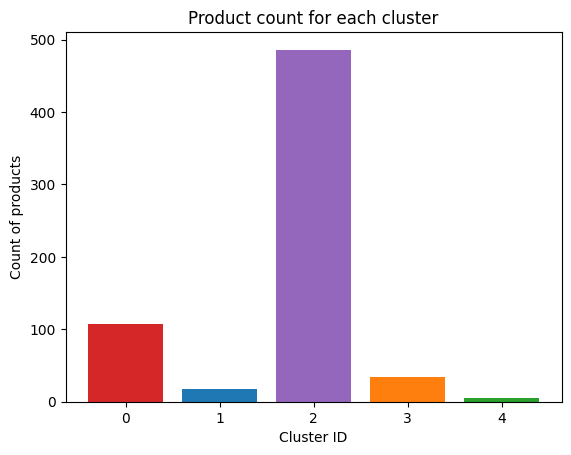

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()


clusters = { 0 : 107,
             1 : 17,
             2 : 486,
             3 : 34,
             4 : 5}

bar_labels = ['red', 'blue', 'purple', 'orange', 'green']
bar_colors = ['tab:red', 'tab:blue', 'tab:purple', 'tab:orange', 'tab:green']

ax.bar(clusters.keys(), clusters.values(), label=bar_labels, color=bar_colors)

ax.set_ylabel('Count of products')
ax.set_xlabel('Cluster ID')
ax.set_title('Product count for each cluster')
#ax.legend(title='Clusters')

plt.show()

In [11]:
df_urunler.to_excel('urun_ozellikleri_processed.xlsx', index=False)

## Hyperparametreleri belirlemek için Tuning

In [ ]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.3 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

# --- Modify your get_two_tower_model function to accept hyperparameters ---
def build_model_for_tuner(hp, num_product_features, num_location_features): # hp is the KerasTuner HyperParameters object
    embedding_dim = hp.Int('embedding_dim', min_value=16, max_value=64, step=16)
    dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=32)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Product Tower
    product_input = tf.keras.layers.Input(shape=(num_product_features,), name='product_input')
    prod_dense1 = tf.keras.layers.Dense(dense_units, activation='relu')(product_input)
    prod_bn1 = tf.keras.layers.BatchNormalization()(prod_dense1)
    prod_dropout1 = tf.keras.layers.Dropout(dropout_rate)(prod_bn1)
    product_embedding = tf.keras.layers.Dense(embedding_dim, activation='linear', name='product_embedding')(prod_dropout1)

    # Location Tower
    location_input = tf.keras.layers.Input(shape=(num_location_features,), name='location_input')
    loc_dense1 = tf.keras.layers.Dense(dense_units, activation='relu')(location_input)
    loc_bn1 = tf.keras.layers.BatchNormalization()(loc_dense1)
    loc_dropout1 = tf.keras.layers.Dropout(dropout_rate)(loc_bn1)
    location_embedding = tf.keras.layers.Dense(embedding_dim, activation='linear', name='location_embedding')(loc_dropout1)

    similarity_score = tf.keras.layers.Dot(axes=1, normalize=True)([product_embedding, location_embedding])
    output_probability = tf.keras.layers.Dense(1, activation='sigmoid')(similarity_score)
    model = tf.keras.models.Model(inputs=[product_input, location_input], outputs=output_probability)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                          loss=tf.keras.losses.BinaryCrossentropy(),
                          metrics=['accuracy'])
    return model

# --- Prepare your full artificial training data (X_prod, X_loc, y_labels from before) ---
# Ensure these are defined from your full training_df before splitting for the tuner
X_prod_full = np.array(training_df['product_features'].tolist(), dtype=np.float32)
X_loc_full = np.array(training_df['location_features'].tolist(), dtype=np.float32)
y_labels_full = training_df['label'].values.astype(np.int64)

# Split a portion of your training data for validation during tuning
X_prod_tune_train, X_prod_tune_val, X_loc_tune_train, X_loc_tune_val, y_tune_train, y_tune_val = train_test_split(
    X_prod_full, X_loc_full, y_labels_full, test_size=0.2, random_state=123, stratify=y_labels_full
)

# --- Instantiate the Tuner ---
# Hyperband is an efficient algorithm for hyperparameter search
tuner = kt.Hyperband(
    # Pass the model-building function with fixed parameters
    hypermodel=lambda hp: build_model_for_tuner(hp, X_prod_tune_train.shape[1], X_loc_tune_train.shape[1]),
    objective='val_accuracy', # Or 'val_loss'
    max_epochs=30, # Max epochs to train a model for one trial
    factor=3,      # Reduction factor for number of models and epochs per bracket
    directory='keras_tuner_dir',
    project_name='ttm_slotting_tuning'
)

# Optional: Add a callback to stop training early if a trial is not improving
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

print("Starting hyperparameter search...")
tuner.search(
    [X_prod_tune_train, X_loc_tune_train],
    y_tune_train,
    epochs=50, # Max epochs tuner can run models for
    validation_data=([X_prod_tune_val, X_loc_tune_val], y_tune_val),
    callbacks=[stop_early],
    verbose=1
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal hyperparameters are:
Embedding Dim: {best_hps.get('embedding_dim')}
Dense Units: {best_hps.get('dense_units')}
Dropout Rate: {best_hps.get('dropout_rate')}
Learning Rate: {best_hps.get('learning_rate')}
""")

# Build the model with the optimal hyperparameters and train it on the full training data
# best_model = tuner.hypermodel.build(best_hps)
# history = best_model.fit([X_prod_full, X_loc_full], y_labels_full, epochs=FINAL_EPOCHS, validation_split=0.1) # Train on all data
# best_model.save('tuned_two_tower_model.keras')

Trial 90 Complete [00h 02m 07s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 46m 23s

The hyperparameter search is complete. The optimal hyperparameters are:
Embedding Dim: 48
Dense Units: 32
Dropout Rate: 0.1
Learning Rate: 0.01



In [ ]:
best_hps.values

{'embedding_dim': 48,
 'dense_units': 32,
 'dropout_rate': 0.1,
 'learning_rate': 0.01,
 'tuner/epochs': 30,
 'tuner/initial_epoch': 10,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '0048'}

## AI MODELI

In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dot, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import joblib # To save/load scalers/encoders

print("TensorFlow Version:", tf.__version__)

# --- 1. Configuration & Parameters ---
# File Paths
PRODUCT_FILE = 'urun_ozellikleri_processed.xlsx'
LAYOUT_FILE = 'depo_layout.xlsx'

# Feature Columns
# Adjust these lists precisely based on your Excel files after initial cleaning
PRODUCT_ID_COL = 'SKU'
PRODUCT_NUMERICAL_COLS = ['Net_Weight', 'Volume', 'Shipment_Frequency'] # Volume calculated below
PRODUCT_CATEGORICAL_COLS = ['ClusterID'] # Example

LOCATION_ID_COL = 'LokasyonID'
LOCATION_NUMERICAL_COLS = ['X_Koordinati', 'Y_Koordinati', 'Z_Koordinati', 'Kat', 'Sevkiyat_Uzakligi', 'Max_Agirlik', 'Max_Hacim']
LOCATION_CATEGORICAL_COLS = ['Tip'] # e.g., 'Ground', 'Middle', 'Top'
LOCATION_OCCUPANCY_COL = 'Dolu_Mu'

# Model Parameters
EMBEDDING_DIM = 48
DENSE_UNITS = 32
DROPOUT_RATE = 0.1
LEARNING_RATE = 0.01

# Training Parameters
EPOCHS = 30 # Adjust based on convergence
BATCH_SIZE = 128
VALIDATION_SPLIT = 0.2

# Artificial Label Generation Rules (Adjust thresholds and logic)
# Using quantiles can make thresholds adaptive to data distribution
HEAVY_THRESHOLD_WEIGHT = 50 # Use actual weight value
HIGH_FREQ_QUANTILE = 0.80   # Top 20% frequency items are 'high'
LOW_DIST_QUANTILE = 0.25    # Closest 25% locations are 'low distance'
NUM_NEG_SAMPLES_PER_POSITIVE = 4 # How many 'bad' examples per 'good' one

# Files to save preprocessors
PRODUCT_SCALER_FILE = 'product_scaler.joblib'
LOCATION_SCALER_FILE = 'location_scaler.joblib'
LOCATION_ENCODER_FILE = 'location_encoder.joblib'
PRODUCT_ENCODER_FILE = 'product_encoder.joblib' # If ClusterID is OHE
MODEL_SAVE_PATH = 'two_tower_slotting_model.keras'

# --- 2. Data Loading and Initial Cleaning ---
print("Loading data...")
try:
    df_products_raw = pd.read_excel(PRODUCT_FILE)
    df_locations_raw = pd.read_excel(LAYOUT_FILE)
    print("Data loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading files: {e}. Make sure Excel files are in the correct path.")
    exit()

# Basic Cleaning - Handle potential explicit missing values if needed
df_products = df_products_raw.dropna(subset=[PRODUCT_ID_COL]).copy()
df_locations = df_locations_raw.dropna(subset=[LOCATION_ID_COL]).copy()

# Ensure boolean type for occupancy
df_locations[LOCATION_OCCUPANCY_COL] = df_locations[LOCATION_OCCUPANCY_COL].astype(bool)

# --- 3. Feature Engineering ---
print("Performing feature engineering...")
# Calculate Volume for products (Add error handling if columns missing)
try:
    df_products['Net_Weight'] = df_products['Net_Weight'] / 1000.0 # Convert to kg
    df_products['Volume'] =  df_products['Volume'] / 1_000_000.0
    print("Volume calculated.")
    print(df_products.head())
except KeyError as e:
    print(f"Error calculating Volume: Missing column {e}. Ensure Length, Width, Height exist.")
    # Handle error: exit or assign default volume
    df_products['Volume'] = 1.0 # Assign default if calculation fails
    if 'Volume' not in PRODUCT_NUMERICAL_COLS: PRODUCT_NUMERICAL_COLS.append('Volume')


# --- 4. Preprocessing ---
print("Preprocessing features...")

# Separate features
product_num_features = df_products[PRODUCT_NUMERICAL_COLS]
product_cat_features = df_products[PRODUCT_CATEGORICAL_COLS]
location_num_features = df_locations[LOCATION_NUMERICAL_COLS]
location_cat_features = df_locations[LOCATION_CATEGORICAL_COLS]

# Fit Scalers (on the whole dataset for consistent scaling across train/test/inference)
product_scaler = MinMaxScaler()
location_scaler = MinMaxScaler()

product_num_scaled = product_scaler.fit_transform(product_num_features)
location_num_scaled = location_scaler.fit_transform(location_num_features)

# Fit Encoders
# Location Type Encoder
location_ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
location_cat_encoded = location_ohe_encoder.fit_transform(location_cat_features)
location_ohe_feature_names = location_ohe_encoder.get_feature_names_out(LOCATION_CATEGORICAL_COLS)

# Product ClusterID Encoder (Example: One-Hot Encoding)
# If ClusterID is numerical and represents magnitude, scaling might be enough.
# If it's purely categorical, OHE or Embedding layer is needed. Let's use OHE here.
product_ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
product_cat_encoded = product_ohe_encoder.fit_transform(product_cat_features)
product_ohe_feature_names = product_ohe_encoder.get_feature_names_out(PRODUCT_CATEGORICAL_COLS)


# Create processed DataFrames (easier to work with)
df_products_processed = pd.DataFrame(product_num_scaled, columns=PRODUCT_NUMERICAL_COLS, index=df_products.index)
df_products_processed[product_ohe_feature_names] = product_cat_encoded
df_products_processed[PRODUCT_ID_COL] = df_products[PRODUCT_ID_COL] # Keep ID
# Store final feature names used in the model
final_product_feature_cols = PRODUCT_NUMERICAL_COLS + product_ohe_feature_names.tolist()

df_locations_processed = pd.DataFrame(location_num_scaled, columns=LOCATION_NUMERICAL_COLS, index=df_locations.index)
df_locations_processed[location_ohe_feature_names] = location_cat_encoded
df_locations_processed[LOCATION_ID_COL] = df_locations[LOCATION_ID_COL] # Keep ID
df_locations_processed[LOCATION_OCCUPANCY_COL] = df_locations[LOCATION_OCCUPANCY_COL] # Keep Occupancy
# Add original columns needed for rules/capacity check
df_locations_processed['Max_Agirlik_orig'] = df_locations_raw['Max_Agirlik']
df_locations_processed['Max_Hacim_orig'] = df_locations_raw['Max_Hacim']
df_locations_processed['Type_orig'] = df_locations_raw['Tip']

# Store final feature names used in the model
final_location_feature_cols = LOCATION_NUMERICAL_COLS + location_ohe_feature_names.tolist()

# Add original cols needed for rules to products_processed too
df_products_processed['Net_Weight_orig'] = df_products_raw['Net_Weight']
df_products_processed['Volume_orig'] = df_products['Volume']
df_products_processed['Shipment_Frequency_orig'] = df_products_raw['Shipment_Frequency']
# Note: Accessing original values might be needed for threshold checks in rules

# Save the fitted preprocessors
joblib.dump(product_scaler, PRODUCT_SCALER_FILE)
joblib.dump(location_scaler, LOCATION_SCALER_FILE)
joblib.dump(location_ohe_encoder, LOCATION_ENCODER_FILE)
joblib.dump(product_ohe_encoder, PRODUCT_ENCODER_FILE)
print("Preprocessors fitted and saved.")

# --- 5. Artificial Label Generation ---
print("Generating artificial training labels based on rules...")

# Calculate dynamic thresholds based on processed data
high_freq_threshold = df_products_processed['Shipment_Frequency'].quantile(HIGH_FREQ_QUANTILE)
low_dist_threshold = df_locations_processed['Sevkiyat_Uzakligi'].quantile(LOW_DIST_QUANTILE)
print(f"Rule Thresholds: Freq > {high_freq_threshold:.2f} (Norm), Dist < {low_dist_threshold:.2f} (Norm), Weight > {HEAVY_THRESHOLD_WEIGHT} (Raw)")

def check_rules(product, location):
    """Checks if a product-location pair is a 'good' match based on rules."""
    # Rule 1: Frequency/Distance
    is_frequent = product['Shipment_Frequency'] > high_freq_threshold
    is_close = location['Sevkiyat_Uzakligi'] < low_dist_threshold
    rule1_met = not is_frequent or (is_frequent and is_close) # Good if not frequent, OR frequent and close

    # Rule 2: Weight/Floor (Using original weight and OHE Type)
    is_heavy = product['Net_Weight_orig'] > HEAVY_THRESHOLD_WEIGHT
    is_ground = location.get('Tip', 0) == "Zemin" # Check if 'Tip_Ground' exists and is 1
    rule2_met = not is_heavy or (is_heavy and is_ground) # Good if not heavy, OR heavy and ground

    # Rule 3: Capacity (Using original values) - Implicitly handled by filtering before this function
    # capacity_met = (product['Volume_orig'] <= location['Max_Hacim_M3_orig']) and \
    #                (product['Weight_orig'] <= location['MaxWeight_KG_orig'])

    # Combine rules (adjust logic as needed, e.g., all must be met?)
    # For this example, let's say capacity must be met (handled outside)
    # and the key rules (freq/dist, weight/floor) must be met.
    return rule1_met and rule2_met

training_samples = []
processed_locations_capacity_valid = df_locations_processed # Will be filtered per product

for prod_idx, product_row in df_products_processed.iterrows():
    positive_locations = []
    negative_pool_indices = [] # Indices of locations meeting capacity but not 'good'

    # Filter locations by capacity for this specific product
    locs_cap_ok = processed_locations_capacity_valid[
        (processed_locations_capacity_valid['Max_Agirlik_orig'] >= product_row['Net_Weight_orig']) &
        (processed_locations_capacity_valid['Max_Hacim_orig'] >= product_row['Volume_orig'])
    ]

    if locs_cap_ok.empty:
        # print(f"Warning: No locations with enough capacity for product {product_row[PRODUCT_ID_COL]}")
        continue # Skip product if no location can hold it

    loc_indices_cap_ok = locs_cap_ok.index.tolist()

    for loc_idx in loc_indices_cap_ok:
        location_row = locs_cap_ok.loc[loc_idx]
        if check_rules(product_row, location_row):
            positive_locations.append(loc_idx)
        else:
            negative_pool_indices.append(loc_idx)

    # Create training samples
    # Add positive samples
    for loc_idx in positive_locations:
        training_samples.append({
            'product_features': product_row[final_product_feature_cols].values,
            'location_features': df_locations_processed.loc[loc_idx][final_location_feature_cols].values,
            'label': 1
        })

        # Add corresponding negative samples
        num_neg_to_add = min(NUM_NEG_SAMPLES_PER_POSITIVE, len(negative_pool_indices))
        if num_neg_to_add > 0:
            neg_indices = np.random.choice(negative_pool_indices, num_neg_to_add, replace=False)
            for neg_idx in neg_indices:
                training_samples.append({
                    'product_features': product_row[final_product_feature_cols].values,
                    'location_features': df_locations_processed.loc[neg_idx][final_location_feature_cols].values,
                    'label': 0
                })
            # Optional: Remove chosen negatives from pool to avoid reuse for the same positive?
            # negative_pool_indices = [idx for idx in negative_pool_indices if idx not in neg_indices]


# Create DataFrame from samples
training_df = pd.DataFrame(training_samples)
if training_df.empty:
     print("Error: No training samples generated. Check rules or data.")
     exit()

print(f"Generated {len(training_df)} training samples ({training_df['label'].sum()} positive).")
# Shuffle the data
training_df = training_df.sample(frac=1, random_state=42).reset_index(drop=True)


# --- 6. Model Definition (Two-Tower) ---
print("Building Two-Tower model...")

num_product_features_final = len(final_product_feature_cols)
num_location_features_final = len(final_location_feature_cols)

# Product Tower
product_input = Input(shape=(num_product_features_final,), name='product_input')
prod_dense1 = Dense(DENSE_UNITS, activation='relu')(product_input)
prod_bn1 = BatchNormalization()(prod_dense1) # Add Batch Norm
prod_dropout1 = Dropout(DROPOUT_RATE)(prod_bn1)
product_embedding = Dense(EMBEDDING_DIM, activation='linear', name='product_embedding')(prod_dropout1)

# Location Tower
location_input = Input(shape=(num_location_features_final,), name='location_input')
loc_dense1 = Dense(DENSE_UNITS, activation='relu')(location_input)
loc_bn1 = BatchNormalization()(loc_dense1) # Add Batch Norm
loc_dropout1 = Dropout(DROPOUT_RATE)(loc_bn1)
location_embedding = Dense(EMBEDDING_DIM, activation='linear', name='location_embedding')(loc_dropout1)

# Interaction (Cosine Similarity)
similarity_score = Dot(axes=1, normalize=True)([product_embedding, location_embedding])

# Output Probability
output_probability = Dense(1, activation='sigmoid')(similarity_score)

# Build Model
two_tower_model = Model(inputs=[product_input, location_input], outputs=output_probability, name="TwoTowerSlottingModel")

# Compile Model
two_tower_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                      loss=BinaryCrossentropy(),
                      metrics=['accuracy'])

print(two_tower_model.summary())

# --- 7. Data Splitting for Training ---
print("Splitting data for training...")
# Prepare inputs as numpy arrays from the lists stored in the DataFrame
X_prod = np.array(training_df['product_features'].tolist(), dtype=np.float32)
X_loc = np.array(training_df['location_features'].tolist(), dtype=np.float32)
y_labels = training_df['label'].values

# Split into training and validation sets
X_prod_train, X_prod_val, X_loc_train, X_loc_val, y_train, y_val = train_test_split(
    X_prod, X_loc, y_labels, test_size=VALIDATION_SPLIT, random_state=42, stratify=y_labels
)

print(f"Training samples: {len(y_train)}, Validation samples: {len(y_val)}")



TensorFlow Version: 2.18.0
Loading data...
Data loaded successfully.
Performing feature engineering...
Volume calculated.
       SKU          Name Product_Group  Net_Weight  Gross_Weight  Width  \
0  R000001    Mama 57 gr          Mama        0.05          57.0    8.0   
1  R000002   Mama 513 gr          Mama        0.50         513.0    7.0   
2  R000003  Mama 1529 gr          Mama        1.50        1529.0   12.0   
3  R000004  Mama 3040 gr          Mama        3.00        3040.0   14.0   
4  R000005    Mama 55 gr          Mama        0.05          55.0    8.0   

   Length  Height  Palet_Standard  Shipment_Frequency    Volume  ClusterID  
0   125.0   320.0            1920                   0  0.320000         12  
1    24.5    14.0             384                  68  0.002401          0  
2    40.0    18.5             108                2039  0.008880          1  
3    49.0    24.5              72                 640  0.016807          6  
4   125.0   320.0            1920         

Model: "TwoTowerSlottingModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ product_input       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ location_input      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        544 │ product_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │        352 │ location_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32)        │        128 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ product_embedding   │ (None, 48)        │      1,584 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ location_embedding  │ (None, 48)        │      1,584 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1)         │          0 │ product_embeddin… │
│                     │                   │            │ location_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │          2 │ dot[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,322 (16.88 KB)

 Trainable params: 4,194 (16.38 KB)

 Non-trainable params: 128 (512.00 B)

None
Splitting data for training...
Training samples: 44672, Validation samples: 11168


In [13]:
print(X_prod_train.shape, X_loc_train.shape, y_train.shape)
print(X_prod_val.shape, X_loc_val.shape, y_val.shape)

(44672, 16) (44672, 10) (44672,)
(11168, 16) (11168, 10) (11168,)


In [14]:
# --- 8. Model Training ---
print("Starting model training...")
history = two_tower_model.fit(
    [X_prod_train, X_loc_train],
    y_train,
    validation_data=([X_prod_val, X_loc_val], y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)
print("Training complete.")

# --- 9. Save Model ---
print(f"Saving trained model to {MODEL_SAVE_PATH}...")
two_tower_model.save(MODEL_SAVE_PATH)
print("Model saved.")

# --- 10. Inference Function ---
print("Defining inference function...")

# Load preprocessors (crucial for inference)
loaded_prod_scaler = joblib.load(PRODUCT_SCALER_FILE)
loaded_loc_scaler = joblib.load(LOCATION_SCALER_FILE)
loaded_loc_encoder = joblib.load(LOCATION_ENCODER_FILE)
loaded_prod_encoder = joblib.load(PRODUCT_ENCODER_FILE)
# Load the trained model
loaded_model = tf.keras.models.load_model(MODEL_SAVE_PATH)

def recommend_location(product_data_dict, available_locations_df):
    """
    Recommends the best location for a single product from available locations.

    Args:
        product_data_dict (dict): Dictionary containing features for the ONE product
                                   (e.g., {'Weight': 60, 'Length': 1, ... 'ClusterID': 2}).
                                   Must contain all raw features needed.
        available_locations_df (pd.DataFrame): DataFrame of AVAILABLE locations
                                              with all necessary raw feature columns.

    Returns:
        str: The LocationID of the recommended location, or None if no suitable location found.
    """
    if available_locations_df.empty:
        print("Inference: No available locations provided.")
        return None

    # --- Preprocess Product Data ---
    try:
        # Create DataFrame for consistent processing
        prod_df_inf = pd.DataFrame([product_data_dict])
        # Calculate Volume if needed
        if 'Volume' not in prod_df_inf.columns:
             prod_df_inf['Volume'] = prod_df_inf['Length'] * prod_df_inf['Width'] * prod_df_inf['Height']

        # Apply scaling
        prod_num_inf = prod_df_inf[PRODUCT_NUMERICAL_COLS]
        prod_num_scaled_inf = loaded_prod_scaler.transform(prod_num_inf)
        # Apply encoding
        prod_cat_inf = prod_df_inf[PRODUCT_CATEGORICAL_COLS]
        prod_cat_encoded_inf = loaded_prod_encoder.transform(prod_cat_inf)

        # Combine features in the correct order
        prod_features_final_inf = np.concatenate(
            [prod_num_scaled_inf, prod_cat_encoded_inf], axis=1
        )
        # Replicate product features for each location
        num_available_locs = len(available_locations_df)
        X_prod_inf = np.repeat(prod_features_final_inf, num_available_locs, axis=0)

    except Exception as e:
        print(f"Error preprocessing product data for inference: {e}")
        return None

    # --- Preprocess Location Data ---
    try:
        locs_df_inf = available_locations_df.copy()
        # Apply scaling
        loc_num_inf = locs_df_inf[LOCATION_NUMERICAL_COLS]
        loc_num_scaled_inf = loaded_loc_scaler.transform(loc_num_inf)
        # Apply encoding
        loc_cat_inf = locs_df_inf[LOCATION_CATEGORICAL_COLS]
        loc_cat_encoded_inf = loaded_loc_encoder.transform(loc_cat_inf)

        # Combine features in the correct order
        X_loc_inf = np.concatenate(
            [loc_num_scaled_inf, loc_cat_encoded_inf], axis=1
        )
    except Exception as e:
        print(f"Error preprocessing location data for inference: {e}")
        return None

    # --- Predict Scores ---
    try:
        scores = loaded_model.predict([X_prod_inf, X_loc_inf], verbose=0) # Set verbose=0 to avoid progress bars
        scores_flat = scores.flatten()

        # --- Find Best Location ---
        best_location_index_in_available = np.argmax(scores_flat)
        recommended_loc_id = available_locations_df.iloc[best_location_index_in_available][LOCATION_ID_COL]
        best_score = scores_flat[best_location_index_in_available]

        print(f"Inference: Scores calculated for {num_available_locs} locations. Best score: {best_score:.4f}")
        return recommended_loc_id

    except Exception as e:
        print(f"Error during prediction or finding best location: {e}")
        return None


# --- 11. Example Usage ---
print("\n--- Example Inference ---")
# Create some dummy data for a new product
new_product = {
    'SKU': 'NEW_PROD_001',
    'Net_Weight': 75, # Heavy
    'Length': 0.8, 'Width': 0.6, 'Height': 0.5, # Volume = 0.24
    'Shipment_Frequency': 150, # Assume this maps to a high normalized value
    'ClusterID': 3 # Example cluster
}

# Get currently available locations from the layout that meet CAPACITY
# IMPORTANT: Filter based on ORIGINAL capacity values
available_locs = df_locations_raw[
    (df_locations_raw[LOCATION_OCCUPANCY_COL] == False) &
    (df_locations_raw['Max_Agirlik'] >= new_product['Net_Weight']) &
    (df_locations_raw['Max_Hacim'] >= (new_product['Length'] * new_product['Width'] * new_product['Height']))
].copy()

if not available_locs.empty:
    recommended_location_id = recommend_location(new_product, available_locs)
    if recommended_location_id:
        print(f"\nRecommended Location for {new_product['SKU']}: {recommended_location_id}")
        # In a real system, you would now mark this location as occupied in df_locations_raw
        # df_locations_raw.loc[df_locations_raw[LOCATION_ID_COL] == recommended_location_id, LOCATION_OCCUPANCY_COL] = True
    else:
        print(f"\nCould not recommend a location for {new_product['SKU']}.")
else:
    print(f"\nNo available locations found with sufficient capacity for {new_product['SKU']}.")

Starting model training...
Epoch 1/30
349/349 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9170 - loss: 0.2419 - val_accuracy: 0.9970 - val_loss: 0.0252
Epoch 2/30
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9970 - loss: 0.0209 - val_accuracy: 0.9970 - val_loss: 0.0133
Epoch 3/30
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9979 - loss: 0.0112 - val_accuracy: 0.9988 - val_loss: 0.0083
Epoch 4/30
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9984 - loss: 0.0079 - val_accuracy: 0.9991 - val_loss: 0.0061
Epoch 5/30
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9987 - loss: 0.0061 - val_accuracy: 0.9987 - val_loss: 0.0049
Epoch 6/30
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9993 - loss: 0.0045 - val_accuracy: 0.9996 - val_loss: 0.0036
Epoch 7/30
349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9995 - loss: 0.0037 - val_accuracy: 0.9991 - val_loss: 0.0034
Epoch 8/30
349/349 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9993 - loss

## Bootstrapping

In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import joblib # Assuming you've saved scalers/encoders
import os

# --- (Previous code for data loading, preprocessing, artificial label generation) ---
# Assume you have:
# training_df: DataFrame with 'product_features', 'location_features', 'label'
# final_product_feature_cols, final_location_feature_cols
# get_two_tower_model(num_prod_feats, num_loc_feats, embedding_dim, dense_units, dropout_rate): a function that defines and compiles your TTM
# EPOCHS, BATCH_SIZE, LEARNING_RATE

# --- New: Bootstrapping and Ensemble Training ---
NUM_BOOTSTRAP_MODELS = 10 # Number of models in the ensemble (adjust as needed)
MODEL_ENSEMBLE_DIR = 'ttm_ensemble_models'
if not os.path.exists(MODEL_ENSEMBLE_DIR):
    os.makedirs(MODEL_ENSEMBLE_DIR)

print(f"Starting training for {NUM_BOOTSTRAP_MODELS} bootstrap models...")

trained_models_paths = []

for i in range(NUM_BOOTSTRAP_MODELS):
    print(f"\n--- Training Bootstrap Model {i+1}/{NUM_BOOTSTRAP_MODELS} ---")

    # 1. Create Bootstrap Sample
    df_bootstrap = training_df.sample(n=len(training_df), replace=True, random_state=42 + i) # Ensure different samples

    # 2. Prepare Data for this Bootstrap Model
    X_prod_b = np.array(df_bootstrap['product_features'].tolist(), dtype=np.float32)
    X_loc_b = np.array(df_bootstrap['location_features'].tolist(), dtype=np.float32)
    y_labels_b = df_bootstrap['label'].values.astype(np.int64)

    # Optional: Split bootstrap sample into train/val for this specific model
    # X_prod_train_b, X_prod_val_b, X_loc_train_b, X_loc_val_b, y_train_b, y_val_b = train_test_split(
    #     X_prod_b, X_loc_b, y_labels_b, test_size=0.1, random_state=42+i, stratify=y_labels_b # Smaller validation set
    # )

    # 3. Define and Compile a new instance of the model
    # (Ensure your get_two_tower_model function correctly defines the input shapes)
    num_prod_feats = X_prod_b.shape[1]
    num_loc_feats = X_loc_b.shape[1]

    # Example: Define get_two_tower_model (you'd have this from previous code)
    def get_two_tower_model(num_product_features, num_location_features, embedding_dim, dense_units, dropout_rate, learning_rate):
        product_input = tf.keras.layers.Input(shape=(num_product_features,), name='product_input')
        prod_dense1 = tf.keras.layers.Dense(dense_units, activation='relu')(product_input)
        prod_bn1 = tf.keras.layers.BatchNormalization()(prod_dense1)
        prod_dropout1 = tf.keras.layers.Dropout(dropout_rate)(prod_bn1)
        product_embedding = tf.keras.layers.Dense(embedding_dim, activation='linear', name='product_embedding')(prod_dropout1)

        location_input = tf.keras.layers.Input(shape=(num_location_features,), name='location_input')
        loc_dense1 = tf.keras.layers.Dense(dense_units, activation='relu')(location_input)
        loc_bn1 = tf.keras.layers.BatchNormalization()(loc_dense1)
        loc_dropout1 = tf.keras.layers.Dropout(dropout_rate)(loc_bn1)
        location_embedding = tf.keras.layers.Dense(embedding_dim, activation='linear', name='location_embedding')(loc_dropout1)

        similarity_score = tf.keras.layers.Dot(axes=1, normalize=True)([product_embedding, location_embedding])
        output_probability = tf.keras.layers.Dense(1, activation='sigmoid')(similarity_score)
        model = tf.keras.models.Model(inputs=[product_input, location_input], outputs=output_probability)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                              loss=tf.keras.losses.BinaryCrossentropy(),
                              metrics=['accuracy'])
        return model

    bootstrap_model = get_two_tower_model(num_prod_feats, num_loc_feats, EMBEDDING_DIM, DENSE_UNITS, DROPOUT_RATE, LEARNING_RATE)


    # 4. Train the Bootstrap Model
    print(f"Training model {i+1}...")
    bootstrap_model.fit(
        [X_prod_b, X_loc_b], # Use the full bootstrap sample for training this model
        y_labels_b,
        # validation_data=([X_prod_val_b, X_loc_val_b], y_val_b), # If using split
        epochs=EPOCHS, # Potentially fewer epochs for bootstrap models if time is a constraint
        batch_size=BATCH_SIZE,
        verbose=0 # Reduce verbosity for multiple trainings
    )

    # 5. Save the Trained Bootstrap Model
    model_path = os.path.join(MODEL_ENSEMBLE_DIR, f'ttm_bootstrap_{i+1}.keras')
    bootstrap_model.save(model_path)
    trained_models_paths.append(model_path)
    print(f"Model {i+1} saved to {model_path}")

print("All bootstrap models trained and saved.")


# --- New: Inference Function using Ensemble ---
# Load all trained models from the ensemble
ensemble_models = []
for model_path in trained_models_paths:
    ensemble_models.append(tf.keras.models.load_model(model_path))
print(f"Loaded {len(ensemble_models)} models for ensemble inference.")

# Assume preprocessors are loaded (loaded_prod_scaler, loaded_loc_scaler, etc.)
# ... (Your existing recommend_location function needs slight modification) ...

def recommend_location_ensemble(product_data_dict, available_locations_df, ensemble_models_list,
                               prod_scaler, loc_scaler, prod_ohe, loc_ohe, # Pass preprocessors
                               product_num_cols, product_cat_cols,
                               location_num_cols, location_cat_cols):
    if available_locations_df.empty:
        print("Ensemble Inference: No available locations provided.")
        return None

    # --- Preprocess Product Data (same as before) ---
    try:
        prod_df_inf = pd.DataFrame([product_data_dict])
        if 'Volume' not in prod_df_inf.columns and all(c in prod_df_inf for c in ['Length', 'Width', 'Height']):
             prod_df_inf['Volume'] = prod_df_inf['Length'] * prod_df_inf['Width'] * prod_df_inf['Height']
        else: prod_df_inf.setdefault('Volume', 1.0)


        prod_num_inf = prod_df_inf[product_num_cols]
        prod_num_scaled_inf = prod_scaler.transform(prod_num_inf)
        prod_cat_inf = prod_df_inf[product_cat_cols]
        prod_cat_encoded_inf = prod_ohe.transform(prod_cat_inf)
        prod_features_final_inf = np.concatenate([prod_num_scaled_inf, prod_cat_encoded_inf], axis=1)
        X_prod_inf = np.repeat(prod_features_final_inf, len(available_locations_df), axis=0)
    except Exception as e:
        print(f"Error preprocessing product data for ensemble inference: {e}")
        return None

    # --- Preprocess Location Data (same as before) ---
    try:
        locs_df_inf = available_locations_df.copy()
        loc_num_inf = locs_df_inf[location_num_cols]
        loc_num_scaled_inf = loc_scaler.transform(loc_num_inf)
        loc_cat_inf = locs_df_inf[location_cat_cols]
        loc_cat_encoded_inf = loc_ohe.transform(loc_cat_inf)
        X_loc_inf = np.concatenate([loc_num_scaled_inf, loc_cat_encoded_inf], axis=1)
    except Exception as e:
        print(f"Error preprocessing location data for ensemble inference: {e}")
        return None

    # --- Predict Scores with Ensemble ---
    all_scores = []
    for model_instance in ensemble_models_list:
        scores = model_instance.predict([X_prod_inf, X_loc_inf], verbose=0)
        all_scores.append(scores.flatten())

    # Average the scores across models
    # Stacking scores: each column is a model's predictions for all locations
    # Each row is all models' predictions for one location
    stacked_scores = np.stack(all_scores, axis=1)
    average_scores = np.mean(stacked_scores, axis=1)

    # --- Find Best Location ---
    best_location_index_in_available = np.argmax(average_scores)
    recommended_loc_id = available_locations_df.iloc[best_location_index_in_available][LOCATION_ID_COL] # Ensure LOCATION_ID_COL is correct
    best_avg_score = average_scores[best_location_index_in_available]

    print(f"Ensemble Inference: Averaged scores from {len(ensemble_models_list)} models. Best avg score: {best_avg_score:.4f}")
    return recommended_loc_id




Starting training for 10 bootstrap models...

--- Training Bootstrap Model 1/10 ---
Training model 1...
Model 1 saved to ttm_ensemble_models/ttm_bootstrap_1.keras

--- Training Bootstrap Model 2/10 ---
Training model 2...
Model 2 saved to ttm_ensemble_models/ttm_bootstrap_2.keras

--- Training Bootstrap Model 3/10 ---
Training model 3...
Model 3 saved to ttm_ensemble_models/ttm_bootstrap_3.keras

--- Training Bootstrap Model 4/10 ---
Training model 4...
Model 4 saved to ttm_ensemble_models/ttm_bootstrap_4.keras

--- Training Bootstrap Model 5/10 ---
Training model 5...
Model 5 saved to ttm_ensemble_models/ttm_bootstrap_5.keras

--- Training Bootstrap Model 6/10 ---
Training model 6...
Model 6 saved to ttm_ensemble_models/ttm_bootstrap_6.keras

--- Training Bootstrap Model 7/10 ---
Training model 7...
Model 7 saved to ttm_ensemble_models/ttm_bootstrap_7.keras

--- Training Bootstrap Model 8/10 ---
Training model 8...
Model 8 saved to ttm_ensemble_models/ttm_bootstrap_8.keras

--- Traini

In [16]:
def recommend_location_ensemble(product_data_dict, available_locations_df, ensemble_models_list,
                               prod_scaler, loc_scaler, prod_ohe, loc_ohe, # Pass preprocessors
                               product_num_cols, product_cat_cols,
                               location_num_cols, location_cat_cols):
    if available_locations_df.empty:
        print("Ensemble Inference: No available locations provided.")
        return None

    # --- Preprocess Product Data ---
    try:
        # Create DataFrame for consistent processing
        prod_df_inf = pd.DataFrame([product_data_dict])

        # Calculate Volume if 'Volume' column doesn't exist but L, W, H do
        if 'Volume' not in prod_df_inf.columns and \
           all(c in prod_df_inf.columns for c in ['Length', 'Width', 'Height']):
            prod_df_inf['Volume'] = prod_df_inf['Length'] * prod_df_inf['Width'] * prod_df_inf['Height']
        elif 'Volume' not in prod_df_inf.columns: # If Volume is still missing, assign default
            print("Warning: 'Volume' not found and L,W,H not available for calculation. Assigning default volume 1.0.")
            prod_df_inf['Volume'] = 1.0 # Assign default if not calculable and not present

        # Ensure all numerical columns expected by the scaler are present, fill with median if necessary
        # This is a safeguard; ideally, product_data_dict should have all required keys
        for col in product_num_cols:
            if col not in prod_df_inf.columns:
                print(f"Warning: Product numerical feature '{col}' missing in input. Using 0 as default.")
                prod_df_inf[col] = 0 # Or use a median from training data if more appropriate

        prod_num_inf = prod_df_inf[product_num_cols]
        prod_num_scaled_inf = prod_scaler.transform(prod_num_inf)

        # Ensure all categorical columns expected by the encoder are present
        for col in product_cat_cols:
            if col not in prod_df_inf.columns:
                 print(f"Warning: Product categorical feature '{col}' missing in input. Using 'Unknown' or mode as default.")
                 # You might need a strategy for missing categorical features, e.g., a common category or a specific 'Unknown' category
                 # For OHE, if 'handle_unknown=ignore' was used, this might be less critical if the feature is just missing.
                 # If a value is expected, you might need to assign a default that was seen during training.
                 # For simplicity here, if a categorical column is entirely missing, and OHE expects it, it might error
                 # It's best if product_data_dict provides all expected keys.
                 # If ClusterID is the only one and is always generated:
                 if col == 'ClusterID': # Example
                     prod_df_inf[col] = -1 # Or a default cluster ID seen during training

        prod_cat_inf = prod_df_inf[product_cat_cols]
        prod_cat_encoded_inf = prod_ohe.transform(prod_cat_inf)

        prod_features_final_inf = np.concatenate([prod_num_scaled_inf, prod_cat_encoded_inf], axis=1)
        X_prod_inf = np.repeat(prod_features_final_inf, len(available_locations_df), axis=0)
    except Exception as e:
        print(f"Error preprocessing product data for ensemble inference: {e}")
        import traceback
        traceback.print_exc() # Print full traceback for more details
        return None

    # --- Preprocess Location Data (same as before) ---
    try:
        locs_df_inf = available_locations_df.copy()
        loc_num_inf = locs_df_inf[location_num_cols]
        loc_num_scaled_inf = loc_scaler.transform(loc_num_inf)
        loc_cat_inf = locs_df_inf[location_cat_cols]
        loc_cat_encoded_inf = loc_ohe.transform(loc_cat_inf)
        X_loc_inf = np.concatenate([loc_num_scaled_inf, loc_cat_encoded_inf], axis=1)
    except Exception as e:
        print(f"Error preprocessing location data for ensemble inference: {e}")
        return None

    # --- Predict Scores with Ensemble ---
    all_scores = []
    for model_instance in ensemble_models_list:
        scores = model_instance.predict([X_prod_inf, X_loc_inf], verbose=0)
        all_scores.append(scores.flatten())

    # Average the scores across models
    # Stacking scores: each column is a model's predictions for all locations
    # Each row is all models' predictions for one location
    stacked_scores = np.stack(all_scores, axis=1)
    average_scores = np.mean(stacked_scores, axis=1)

    # --- Find Best Location ---
    best_location_index_in_available = np.argmax(average_scores)
    recommended_loc_id = available_locations_df.iloc[best_location_index_in_available][LOCATION_ID_COL] # Ensure LOCATION_ID_COL is correct
    best_avg_score = average_scores[best_location_index_in_available]

    print(f"Ensemble Inference: Averaged scores from {len(ensemble_models_list)} models. Best avg score: {best_avg_score:.4f}")
    return recommended_loc_id


In [17]:
# --- Example Ensemble Inference ---
# Create some dummy data for a new product
new_product = {
    'SKU': 'NEW_PROD_002',
    'Net_Weight': 25, # Heavy
    'Length': 0.8, 'Width': 0.6, 'Height': 0.5, # Volume = 0.24
    'Shipment_Frequency': 450, # Assume this maps to a high normalized value
    'ClusterID': 5 # Example cluster
}

# Get currently available locations from the layout that meet CAPACITY
# IMPORTANT: Filter based on ORIGINAL capacity values
available_locs = df_locations_raw[
    (df_locations_raw[LOCATION_OCCUPANCY_COL] == False) &
    (df_locations_raw['Max_Agirlik'] >= new_product['Net_Weight']) &
    (df_locations_raw['Max_Hacim'] >= (new_product['Length'] * new_product['Width'] * new_product['Height']))
].copy()
if not available_locs.empty:
    recommended_loc_ensemble = recommend_location_ensemble(
        new_product, available_locs, ensemble_models,
        loaded_prod_scaler, loaded_loc_scaler, loaded_prod_encoder, loaded_loc_encoder,
        PRODUCT_NUMERICAL_COLS, PRODUCT_CATEGORICAL_COLS,
        LOCATION_NUMERICAL_COLS, LOCATION_CATEGORICAL_COLS
    )
    if recommended_loc_ensemble:
        print(f"\nEnsemble Recommended Location for {new_product['SKU']}: {recommended_loc_ensemble}")
    else:
        print(f"\nEnsemble could not recommend a location for {new_product['SKU']}.")
else:
    print(f"\nNo available locations found with sufficient capacity for {new_product['SKU']}.")

Ensemble Inference: Averaged scores from 10 models. Best avg score: 1.0000

Ensemble Recommended Location for NEW_PROD_002: C3-S2-K11-L2


# Unity Simulation Preps

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import joblib # To load your scalers and KMeans model
# Assume your TTM ensemble and recommend_location_ensemble are defined/loadable

# --- Constants from your TTM script ---
PRODUCT_NUMERICAL_COLS_FOR_CLUSTERING = ['Net_Weight', 'Volume', 'Shipment_Frequency']
# ... other constants like PRODUCT_ID_COL, LOCATION_ID_COL etc.

# --- Load Pre-trained Models/Preprocessors ---
try:
    product_scaler = joblib.load('product_scaler.joblib') # Scaler used for TTM training
    #final_kmeans_model = joblib.load('final_kmeans_model.joblib') # Your fitted KMeans
    # ensemble_models = [...] # Load your TTM ensemble
    # loaded_loc_scaler, loaded_prod_encoder, loaded_loc_encoder = ... # Load these too
    print("Preprocessors and KMeans model loaded.")
except FileNotFoundError as e:
    print(f"Error loading saved models/preprocessors: {e}. Ensure they are saved correctly.")
    exit()

# --- 1. Define Product Feature Distributions ---
def generate_random_products(num_products=640):
    products = []
    for i in range(num_products):
        sku = f"PROD_{i+1:04d}"
        weight = max(100, np.random.normal(4312, 16906)) / 1000 # Min 0.1kg
        length = max(1, np.random.normal(24, 60))#np.random.uniform(0.2, 125)
        width =  max(7, np.random.normal(10, 2.77))#np.random.uniform(1, 20.0)
        height = max(5.6, np.random.normal(32, 127))#np.random.uniform(5.6, 320)
        volume = length * width * height  / 1000_000
        # Example frequency: tiers
        rand_freq = np.random.rand()
        if rand_freq < 0.25: # High Freq
            shipping_frequency = np.random.randint(2161, 9000)
        elif rand_freq < 0.55: # Medium Freq
            shipping_frequency = np.random.randint(181, 2160)
        else: # Low Freq
            shipping_frequency = np.random.randint(1, 180)

        products.append({
            'SKU': sku,
            'Net_Weight': weight, 'Length': length, 'Width': width, 'Height': height,
            'Volume': volume, 'Shipment_Frequency': shipping_frequency
        })
    return pd.DataFrame(products)

# --- 2. Generate Products ---
df_generated_products = generate_random_products(640)
print(f"Generated {len(df_generated_products)} products.")

# --- 3. Cluster New Products ---
# Scale features FOR CLUSTERING using the *same scaler* as during TTM feature prep
product_features_to_scale_for_clustering = df_generated_products[PRODUCT_NUMERICAL_COLS_FOR_CLUSTERING].copy()
# Handle potential NaNs if your generation process could create them (unlikely with example)
product_features_to_scale_for_clustering.fillna(product_features_to_scale_for_clustering.median(), inplace=True)

scaled_features_for_clustering = product_scaler.transform(product_features_to_scale_for_clustering) # Use transform!
df_generated_products['ClusterID'] = final_kmeans.predict(scaled_features_for_clustering)
print(df_generated_products['ClusterID'].value_counts())
print("Products clustered.")

Preprocessors and KMeans model loaded.
Generated 640 products.
ClusterID
0     530
10     74
4      17
9      16
11      2
5       1
Name: count, dtype: int64
Products clustered.


In [19]:
# Group by 'cluster_id' and apply aggregation functions
summary_statistics = df_generated_products.groupby('ClusterID')[['Volume', 'Net_Weight', 'Shipment_Frequency']].agg(['mean', 'median', 'std', 'min', 'max', 'count'])

# You can also get more detailed statistics using .describe() on grouped data
# for column_name in ['column1', 'column2']:
#     print(f"Summary for {column_name}:")
#     print(df.groupby('cluster_id')[column_name].describe())

print(summary_statistics)

             Volume                                               Net_Weight  \
               mean    median       std       min       max count       mean   
ClusterID                                                                      
0          0.016147  0.002686  0.026691  0.000039  0.124026   530   7.655837   
4          0.200436  0.164178  0.082976  0.120176  0.389239    17   5.094512   
5          0.170828  0.170828       NaN  0.170828  0.170828     1  24.975564   
9          0.017874  0.003104  0.034712  0.000039  0.135747    16  42.589055   
10         0.016304  0.002508  0.035266  0.000039  0.194972    74  10.827817   
11         0.467361  0.467361  0.163628  0.351658  0.583063     2   2.595201   

                                                             \
              median        std        min        max count   
ClusterID                                                     
0           3.523662   9.407552   0.100000  39.643916   530   
4           2.758227   6.54

In [20]:


# --- 4. Load Layout ---
try:
    df_locations_raw = pd.read_excel('depo_layout.xlsx')
    df_locations_raw[LOCATION_OCCUPANCY_COL] = False # Initialize all as not occupied
    df_locations_raw['Occupying_SKU'] = None
    print(f"Loaded {len(df_locations_raw)} locations.")
except FileNotFoundError:
    print("Error: depo_layout.xlsx not found.")
    exit()


# --- 5. Scenario 1: Random Placement ---
print("\nStarting Random Placement...")
df_locations_random = df_locations_raw.copy()
random_placements_list = []
unplaced_random_count = 0

for idx, product_row in df_generated_products.iterrows():
    sku = product_row[PRODUCT_ID_COL]
    prod_weight = product_row['Net_Weight'] / 1000
    prod_volume = product_row['Volume'] / 100_000

    suitable_locs = df_locations_random[
        (df_locations_random[LOCATION_OCCUPANCY_COL] == False) &
        (df_locations_random['Max_Agirlik'] >= prod_weight) &
        (df_locations_random['Max_Hacim'] >= prod_volume)
    ]

    if not suitable_locs.empty:
        chosen_loc_idx = np.random.choice(suitable_locs.index)
        chosen_loc_id = df_locations_random.loc[chosen_loc_idx, LOCATION_ID_COL]
        df_locations_random.loc[chosen_loc_idx, LOCATION_OCCUPANCY_COL] = True
        df_locations_random.loc[chosen_loc_idx, 'Occupying_SKU'] = sku
        random_placements_list.append({'SKU': sku, 'LocationID': chosen_loc_id, 'Method': 'Random'})
    else:
        print(f"Random: No suitable location for {sku}")
        random_placements_list.append({'SKU': sku, 'LocationID': 'UNPLACED', 'Method': 'Random'})
        unplaced_random_count +=1

df_random_placements = pd.DataFrame(random_placements_list)
df_random_placements.to_csv('random_placement_output.csv', index=False)
print(f"Random placement complete. {unplaced_random_count} products unplaced. Output saved to random_placement_output.csv")
print("Random placement sample:\n", df_random_placements.head())

Loaded 640 locations.

Starting Random Placement...
Random placement complete. 0 products unplaced. Output saved to random_placement_output.csv
Random placement sample:
          SKU    LocationID  Method
0  PROD_0001   C6-S2-K9-L3  Random
1  PROD_0002   C6-S2-K1-L1  Random
2  PROD_0003   C6-S1-K8-L4  Random
3  PROD_0004   C3-S1-K6-L4  Random
4  PROD_0005  C6-S2-K11-L1  Random


In [21]:



# --- 6. Scenario 2: Model-Based Placement ---
print("\nStarting Model-Based Placement...")
df_locations_model = df_locations_raw.copy() # Fresh copy of layout
model_placements_list = []
unplaced_model_count = 0

# Ensure your recommend_location_ensemble function is loaded/defined
# and ensemble_models, preprocessors are available
# For example:
# ensemble_models = [...] # list of loaded TTM model instances
# loaded_prod_scaler = joblib.load(PRODUCT_SCALER_FILE)
# loaded_loc_scaler = joblib.load(LOCATION_SCALER_FILE)
# loaded_prod_encoder = joblib.load(PRODUCT_ENCODER_FILE) # Used for ClusterID if OHE
# loaded_loc_encoder = joblib.load(LOCATION_ENCODER_FILE) # Used for Location Type


# Sort products by some priority if desired (e.g. high frequency first)
# df_generated_products_sorted = df_generated_products.sort_values(by='ShippingFrequency', ascending=False)
df_generated_products_sorted = df_generated_products # Or use original order

for idx, product_row in df_generated_products_sorted.iterrows():
    sku = product_row[PRODUCT_ID_COL]
    prod_weight = product_row['Net_Weight']
    prod_volume = product_row['Volume']

    product_data_dict_for_model = product_row.to_dict() # Pass all necessary raw features

    available_locs_for_model = df_locations_model[
        (df_locations_model[LOCATION_OCCUPANCY_COL] == False) &
        (df_locations_model['Max_Agirlik'] >= prod_weight) &
        (df_locations_model['Max_Hacim'] >= prod_volume)
    ].copy() # Pass a copy

    if not available_locs_for_model.empty:
        # Replace placeholder with your actual function call:
        # recommended_loc_id = recommend_location_ensemble(
        #     product_data_dict_for_model,
        #     available_locs_for_model,
        #     ensemble_models, # Your list of loaded Keras models
        #     loaded_prod_scaler, loaded_loc_scaler,
        #     loaded_prod_encoder, loaded_loc_encoder,
        #     PRODUCT_NUMERICAL_COLS, PRODUCT_CATEGORICAL_COLS, # Feature names for preprocessing
        #     LOCATION_NUMERICAL_COLS, LOCATION_CATEGORICAL_COLS
        # )
        recommended_loc_id = recommend_location_ensemble(
            product_data_dict_for_model, available_locs_for_model, ensemble_models, # Pass dummy ensemble for placeholder
            loaded_prod_scaler, loaded_loc_scaler, loaded_prod_encoder, loaded_loc_encoder, # Pass dummy encoders if not used by placeholder
            PRODUCT_NUMERICAL_COLS_FOR_CLUSTERING, PRODUCT_CATEGORICAL_COLS, # Example feature names
            LOCATION_NUMERICAL_COLS, LOCATION_CATEGORICAL_COLS
        )


        if recommended_loc_id:
            # Find the index of the recommended location in df_locations_model
            chosen_loc_idx_series = df_locations_model[df_locations_model[LOCATION_ID_COL] == recommended_loc_id].index
            if not chosen_loc_idx_series.empty:
                chosen_loc_idx = chosen_loc_idx_series[0]
                df_locations_model.loc[chosen_loc_idx, LOCATION_OCCUPANCY_COL] = True
                df_locations_model.loc[chosen_loc_idx, 'Occupying_SKU'] = sku
                model_placements_list.append({'SKU': sku, 'LocationID': recommended_loc_id, 'Method': 'Model'})
            else:
                print(f"Model: Recommended LocationID {recommended_loc_id} not found in original layout for SKU {sku}. Placing randomly from available.")
                # Fallback or error handling if recommended_loc_id isn't valid in current context
                # For now, let's pick a random one from available_locs_for_model as a simple fallback
                fallback_idx = np.random.choice(available_locs_for_model.index)
                fallback_loc_id = available_locs_for_model.loc[fallback_idx, LOCATION_ID_COL]
                df_locations_model.loc[fallback_idx, LOCATION_OCCUPANCY_COL] = True
                df_locations_model.loc[fallback_idx, 'Occupying_SKU'] = fallback_loc_id
                model_placements_list.append({'SKU': sku, 'LocationID': fallback_loc_id, 'Method': 'Model_Fallback_Random'})

        else:
            # print(f"Model: No location recommended by TTM for {sku} from available. Unplaced.")
            model_placements_list.append({'SKU': sku, 'LocationID': 'UNPLACED', 'Method': 'Model'})
            unplaced_model_count += 1
    else:
        # print(f"Model: No suitable capacity location for {sku}")
        model_placements_list.append({'SKU': sku, 'LocationID': 'UNPLACED', 'Method': 'Model'})
        unplaced_model_count += 1

df_model_placements = pd.DataFrame(model_placements_list)
df_model_placements.to_csv('model_placement_output.csv', index=False)
print(f"Model-based placement complete. {unplaced_model_count} products unplaced. Output saved to model_placement_output.csv")
print("Model placement sample:\n", df_model_placements.head())


Starting Model-Based Placement...
Ensemble Inference: Averaged scores from 10 models. Best avg score: 0.9997
Ensemble Inference: Averaged scores from 10 models. Best avg score: 1.0000
Ensemble Inference: Averaged scores from 10 models. Best avg score: 1.0000
Ensemble Inference: Averaged scores from 10 models. Best avg score: 1.0000
Ensemble Inference: Averaged scores from 10 models. Best avg score: 1.0000
Ensemble Inference: Averaged scores from 10 models. Best avg score: 1.0000
Ensemble Inference: Averaged scores from 10 models. Best avg score: 1.0000
Ensemble Inference: Averaged scores from 10 models. Best avg score: 1.0000
Ensemble Inference: Averaged scores from 10 models. Best avg score: 1.0000
Ensemble Inference: Averaged scores from 10 models. Best avg score: 1.0000
Ensemble Inference: Averaged scores from 10 models. Best avg score: 1.0000
Ensemble Inference: Averaged scores from 10 models. Best avg score: 1.0000
Ensemble Inference: Averaged scores from 10 models. Best avg scor

In [22]:
df_generated_products.to_csv('generated_products.csv', index=False)

## Summary

In [23]:
df_locations_raw_copy = df_locations_raw.copy()
df_locations_raw_copy = df_locations_raw_copy.rename(columns={'LokasyonID': 'LocationID', 'Sevkiyat_Uzakligi': 'DistanceToExit'})

In [24]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform # For pairwise distances

# --- Assume these DataFrames are loaded and populated ---
# df_generated_products: SKU, Weight, Volume, ShippingFrequency, ClusterID, ...
# df_locations_raw: LocationID, X_Koordinati, Y_Koordinati, DistanceToExit, Type_Ground (OHE), MaxWeight_KG, Max_Hacim_M3, ...
# df_random_placements: SKU, LocationID (from random placement)
# df_model_placements: SKU, LocationID (from model placement)

# --- Merge placement data with product and location details ---
def enrich_placement_data(df_placements, df_products, df_locs):
    df = pd.merge(df_placements, df_products, on='SKU', how='left')
    df = pd.merge(df, df_locs, on='LocationID', how='left')
    # Filter out unplaced items for distance-based metrics
    df_placed = df[df['LocationID'] != 'UNPLACED'].copy()
    return df_placed, df[df['LocationID'] == 'UNPLACED']

df_random_placed_enriched, df_random_unplaced = enrich_placement_data(df_random_placements, df_generated_products, df_locations_raw_copy)
df_model_placed_enriched, df_model_unplaced = enrich_placement_data(df_model_placements, df_generated_products, df_locations_raw_copy)

print(f"Random Placement: {len(df_random_unplaced)} unplaced products.")
print(f"Model Placement:  {len(df_model_unplaced)} unplaced products.")

# --- Define Thresholds (from your rule generation or analysis) ---
# Ensure these are consistent with how you defined them for TTM training
HIGH_FREQ_THRESHOLD_VALUE = df_generated_products['Shipment_Frequency'].quantile(0.80) # Example
HEAVY_THRESHOLD_WEIGHT_VALUE = 50 # Example

# --- Metric 1: Average Distance to Exit for High-Frequency Items ---
def avg_dist_high_freq(df_placed_enriched, freq_threshold):
    high_freq_items = df_placed_enriched[df_placed_enriched['Shipment_Frequency'] >= freq_threshold]
    if high_freq_items.empty:
        return np.nan
    return high_freq_items['DistanceToExit'].mean()

avg_dist_hf_random = avg_dist_high_freq(df_random_placed_enriched, HIGH_FREQ_THRESHOLD_VALUE)
avg_dist_hf_model  = avg_dist_high_freq(df_model_placed_enriched, HIGH_FREQ_THRESHOLD_VALUE)
print(f"\nAvg. Distance for High-Freq Items (Random): {avg_dist_hf_random:.2f}")
print(f"Avg. Distance for High-Freq Items (Model):  {avg_dist_hf_model:.2f}")

# --- Metric 2: Percentage of Heavy Items on Correct Floor ---
def perc_heavy_on_ground(df_placed_enriched, heavy_threshold):
    heavy_items = df_placed_enriched[df_placed_enriched['Net_Weight'] / 1000 >= heavy_threshold] # Assuming 'Weight' is raw weight
    if heavy_items.empty:
        return np.nan
    # Assuming 'Type_Ground' is a 0/1 OHE column in df_locations_raw. Adjust if 'Type' is categorical.
    correctly_placed_heavy = heavy_items[heavy_items.get('Tip', 0) == "Zemin"] # Use .get for safety
    return (len(correctly_placed_heavy) / len(heavy_items)) * 100 if len(heavy_items) > 0 else 0

perc_heavy_ground_random = perc_heavy_on_ground(df_random_placed_enriched, HEAVY_THRESHOLD_WEIGHT_VALUE)
perc_heavy_ground_model  = perc_heavy_on_ground(df_model_placed_enriched, HEAVY_THRESHOLD_WEIGHT_VALUE)
print(f"\n% Heavy Items on Ground (Random): {perc_heavy_ground_random:.2f}%")
print(f"% Heavy Items on Ground (Model):  {perc_heavy_ground_model:.2f}%")


# --- Metric 3: Cluster Cohesion (Average Pairwise Distance within Clusters) ---
def avg_cluster_cohesion(df_placed_enriched):
    all_cluster_avg_distances = []
    if 'ClusterID' not in df_placed_enriched.columns or \
       'X_Koordinati' not in df_placed_enriched.columns or \
       'Y_Koordinati' not in df_placed_enriched.columns:
        print("Warning: Missing ClusterID or Coordinate columns for cohesion calculation.")
        return np.nan

    for cluster_id in df_placed_enriched['ClusterID'].unique():
        cluster_items = df_placed_enriched[df_placed_enriched['ClusterID'] == cluster_id]
        if len(cluster_items) < 2: # Need at least 2 items to calculate pairwise distance
            continue

        # Get coordinates of items in the cluster
        coords = cluster_items[['X_Koordinati', 'Y_Koordinati']].values
        if coords.shape[0] > 1:
            # Calculate pairwise Euclidean distances
            dist_matrix = squareform(pdist(coords, 'euclidean'))
            # Sum of upper triangle (excluding diagonal) and divide by number of pairs
            avg_dist = np.sum(np.triu(dist_matrix, k=1)) / (len(cluster_items) * (len(cluster_items) - 1) / 2)
            all_cluster_avg_distances.append(avg_dist)

    return np.mean(all_cluster_avg_distances) if all_cluster_avg_distances else np.nan

cohesion_random = avg_cluster_cohesion(df_random_placed_enriched)
cohesion_model  = avg_cluster_cohesion(df_model_placed_enriched)
print(f"\nAvg. Intra-Cluster Pairwise Distance (Random): {cohesion_random:.2f} (Lower is better)")
print(f"Avg. Intra-Cluster Pairwise Distance (Model):  {cohesion_model:.2f} (Lower is better)")


# --- Metric 4: Average Overall Distance to Exit (Weighted by Frequency) ---
def weighted_avg_dist_overall(df_placed_enriched):
    if df_placed_enriched.empty or 'Shipment_Frequency' not in df_placed_enriched.columns or 'DistanceToExit' not in df_placed_enriched.columns:
        return np.nan
    weighted_dist_sum = (df_placed_enriched['Shipment_Frequency'] * df_placed_enriched['DistanceToExit']).sum()
    total_freq_sum = df_placed_enriched['Shipment_Frequency'].sum()
    return weighted_dist_sum / total_freq_sum if total_freq_sum > 0 else np.nan

overall_weighted_dist_random = weighted_avg_dist_overall(df_random_placed_enriched)
overall_weighted_dist_model  = weighted_avg_dist_overall(df_model_placed_enriched)
print(f"\nOverall Freq-Weighted Avg Distance (Random): {overall_weighted_dist_random:.2f}")
print(f"Overall Freq-Weighted Avg Distance (Model):  {overall_weighted_dist_model:.2f}")

# --- Prepare a Summary Table ---
results_summary = pd.DataFrame({
    'Metric': [
        'Unplaced Products',
        'Avg. Dist High-Freq',
        '% Heavy on Ground',
        'Avg. Intra-Cluster Dist',
        'Overall Weighted Avg Dist'
    ],
    'Random Placement': [
        len(df_random_unplaced),
        avg_dist_hf_random,
        perc_heavy_ground_random,
        cohesion_random,
        overall_weighted_dist_random
    ],
    'Model Placement': [
        len(df_model_unplaced),
        avg_dist_hf_model,
        perc_heavy_ground_model,
        cohesion_model,
        overall_weighted_dist_model
    ]
})
print("\n\n--- Performance Comparison Summary ---")
print(results_summary.to_string(index=False))

Random Placement: 0 unplaced products.
Model Placement:  0 unplaced products.

Avg. Distance for High-Freq Items (Random): 12.38
Avg. Distance for High-Freq Items (Model):  11.12

% Heavy Items on Ground (Random): nan%
% Heavy Items on Ground (Model):  nan%

Avg. Intra-Cluster Pairwise Distance (Random): 8.24 (Lower is better)
Avg. Intra-Cluster Pairwise Distance (Model):  8.57 (Lower is better)

Overall Freq-Weighted Avg Distance (Random): 12.39
Overall Freq-Weighted Avg Distance (Model):  11.41


--- Performance Comparison Summary ---
                   Metric  Random Placement  Model Placement
        Unplaced Products          0.000000         0.000000
      Avg. Dist High-Freq         12.379297        11.124844
        % Heavy on Ground               NaN              NaN
  Avg. Intra-Cluster Dist          8.242362         8.571796
Overall Weighted Avg Dist         12.394732        11.414672


In [25]:
df_random_placed_enriched

,SKU,LocationID,Method,Net_Weight,Length,Width,Height,Volume,Shipment_Frequency,ClusterID,...,Kat,X_Koordinati,Y_Koordinati,Z_Koordinati,Tip,Max_Hacim,Max_Agirlik,DistanceToExit,Dolu_Mu,Occupying_SKU
0,PROD_0001,C6-S2-K9-L3,Random,30.034237,42.840443,13.376138,93.003480,0.053295,5846,10,...,3,8.5,21.5,3,Orta,1,1000,12.90,False,None
1,PROD_0002,C6-S2-K1-L1,Random,0.100000,12.120005,7.000000,248.414461,0.021075,2000,0,...,1,0.5,21.5,1,Zemin,1,1000,18.72,False,None
2,PROD_0003,C6-S1-K8-L4,Random,0.100000,39.058792,11.365577,179.085168,0.079501,1460,0,...,4,7.5,20.5,4,Orta,1,1000,12.75,False,None
3,PROD_0004,C3-S1-K6-L4,Random,11.333903,57.817875,8.063990,59.864811,0.027912,519,0,...,4,5.5,8.5,4,Orta,1,1000,10.79,False,None
4,PROD_0005,C6-S2-K11-L1,Random,21.401836,49.398254,7.302534,5.600000,0.002020,109,0,...,1,10.5,21.5,1,Zemin,1,1000,11.85,False,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,PROD_0636,C6-S1-K2-L2,Random,0.100000,15.019611,7.000000,246.897704,0.025958,766,0,...,2,1.5,20.5,2,Orta,1,1000,17.33,False,None
636,PROD_0637,C5-S1-K12-L2,Random,0.100000,1.000000,12.204363,108.059406,0.001319,139,0,...,2,11.5,16.5,2,Orta,1,1000,7.11,False,None
637,PROD_0638,C3-S1-K5-L4,Random,0.100000,1.000000,7.000000,213.916777,0.001497,2242,0,...,4,4.5,8.5,4,Orta,1,1000,11.77,False,None
638,PROD_0639,C4-S2-K5-L5,Random,0.100000,1.000000,7.000000,24.168952,0.000169,112,0,...,5,4.5,13.5,5,Ust,1,1000,11.77,False,None



--- Generating Performance Comparison Bar Charts ---
Saved chart: comparison_chart_unplaced_products.png


<ipython-input-26-03553436f491>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=placement_methods, y=metric_values, palette="viridis") # You can choose other palettes


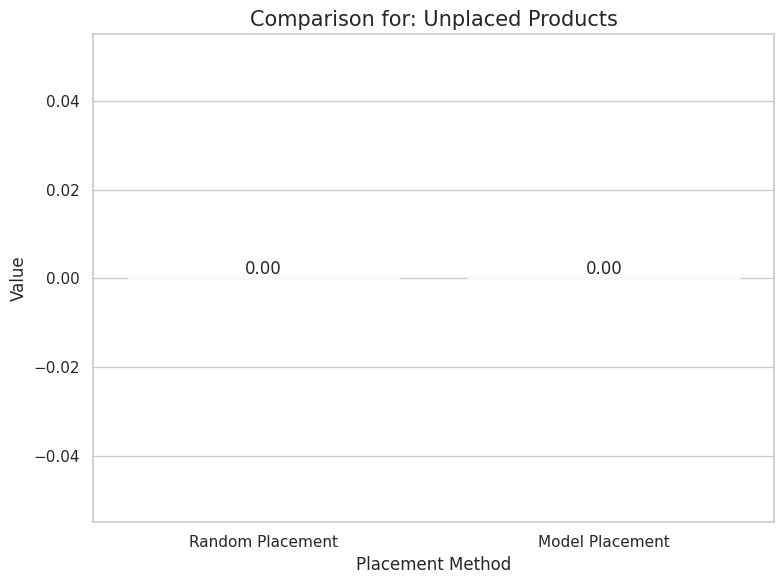

<ipython-input-26-03553436f491>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=placement_methods, y=metric_values, palette="viridis") # You can choose other palettes


Saved chart: comparison_chart_avg_dist_high-freq.png


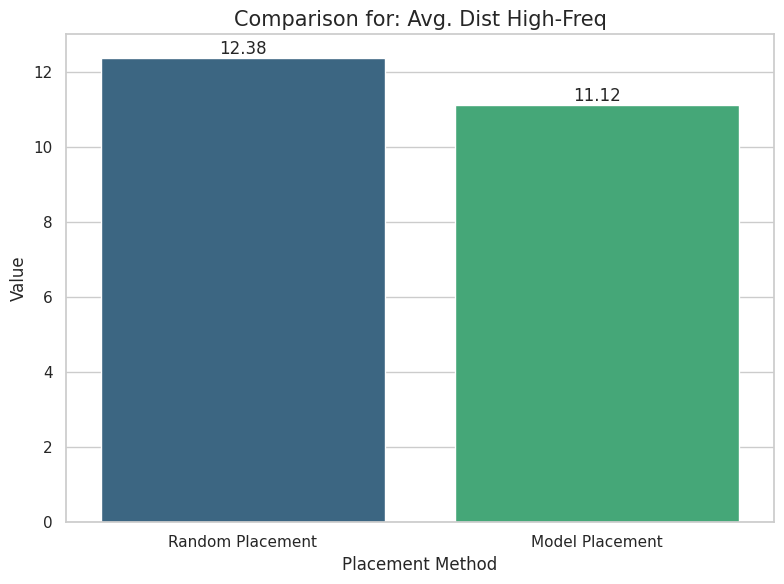

<ipython-input-26-03553436f491>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=placement_methods, y=metric_values, palette="viridis") # You can choose other palettes


Saved chart: comparison_chart_perc_heavy_on_ground.png


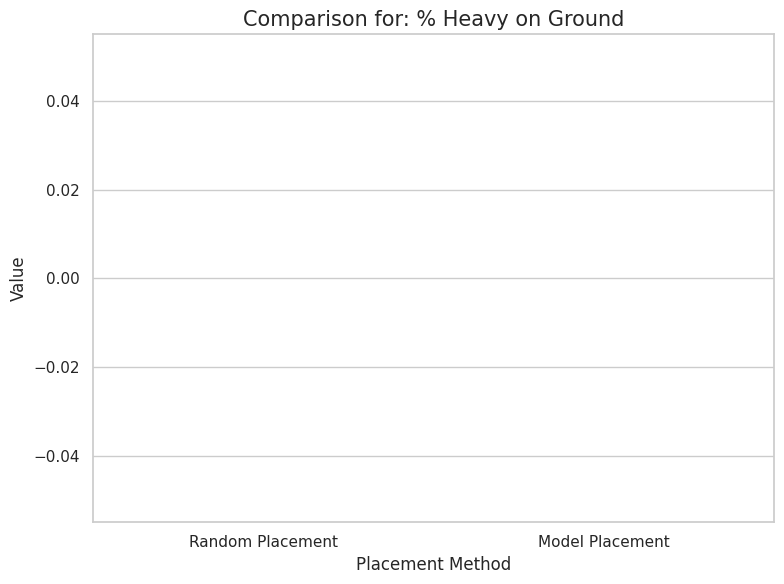

<ipython-input-26-03553436f491>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=placement_methods, y=metric_values, palette="viridis") # You can choose other palettes


Saved chart: comparison_chart_avg_intra-cluster_dist.png


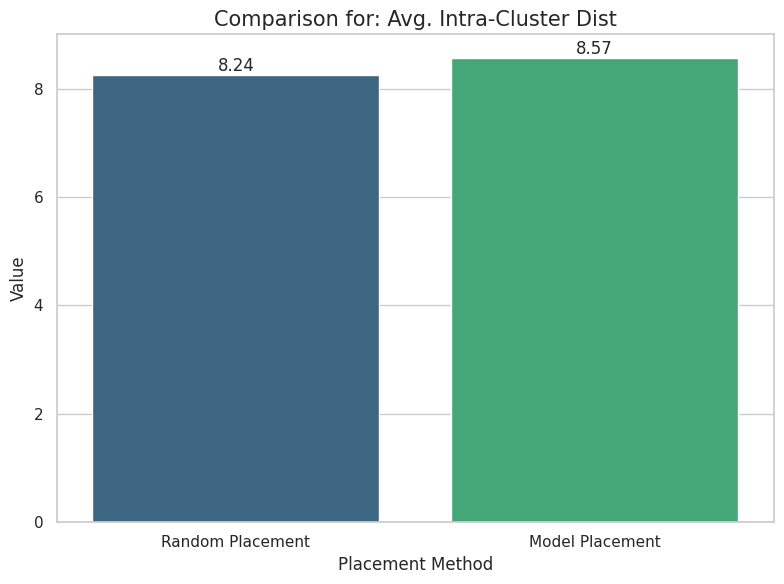

<ipython-input-26-03553436f491>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=placement_methods, y=metric_values, palette="viridis") # You can choose other palettes


Saved chart: comparison_chart_overall_weighted_avg_dist.png


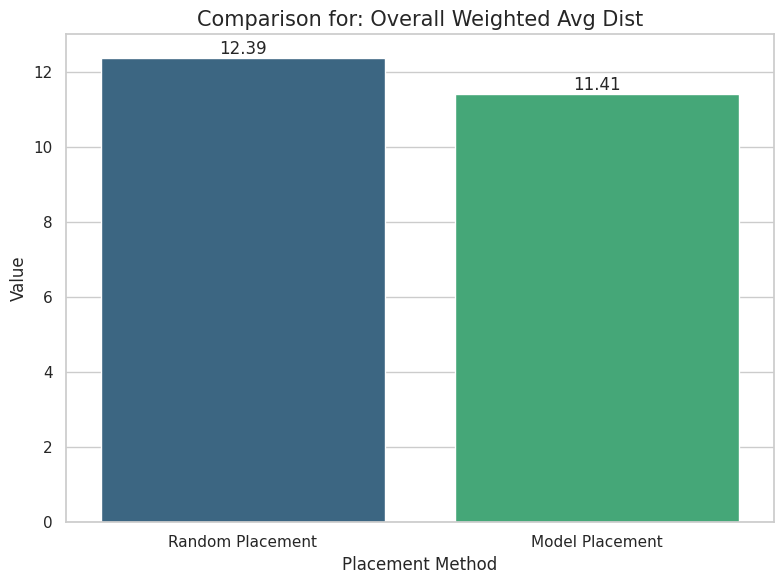


All comparison charts generated and saved.


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # For np.nan handling if needed

# --- Assume results_summary DataFrame is already created ---
# Example data (replace with your actual results_summary DataFrame)
if 'results_summary' not in locals(): # Create dummy if not existing
    print("Creating dummy results_summary DataFrame for plotting demonstration...")
    results_summary = pd.DataFrame({
        'Metric': [
            'Unplaced Products',
            'Avg. Dist High-Freq',
            '% Heavy on Ground',
            'Avg. Intra-Cluster Dist',
            'Overall Weighted Avg Dist'
        ],
        'Random Placement': [
            240,
            150.75,
            30.25,
            80.50,
            120.60
        ],
        'Model Placement': [
            50,
            75.30,
            85.70,
            40.15,
            65.20
        ]
    })

print("\n--- Generating Performance Comparison Bar Charts ---")

# Set a nice style for the plots
sns.set_theme(style="whitegrid")

# Iterate through each metric to create a separate bar chart
# This makes each chart clearer and easier to discuss individually.
metrics_to_plot = results_summary['Metric'].tolist()
placement_methods = ['Random Placement', 'Model Placement']

for metric_name in metrics_to_plot:
    plt.figure(figsize=(8, 6)) # Adjust figure size as needed

    metric_values = results_summary[results_summary['Metric'] == metric_name][placement_methods].values.flatten()

    # Handle potential NaN values if a metric couldn't be calculated (e.g. no heavy items)
    # If you expect NaNs, decide how to plot them (e.g., plot as 0 with a note, or skip plotting that metric)
    # For this example, we'll assume values are numbers. If NaNs, they might cause errors or be ignored by barplot.
    # To plot NaNs as 0: metric_values = np.nan_to_num(metric_values)


    bar_plot = sns.barplot(x=placement_methods, y=metric_values, palette="viridis") # You can choose other palettes

    # Add value labels on top of bars for clarity
    for i in bar_plot.containers:
        bar_plot.bar_label(i, fmt='%.2f') # Format to 2 decimal places

    plt.title(f'Comparison for: {metric_name}', fontsize=15)
    plt.ylabel('Value', fontsize=12)
    plt.xlabel('Placement Method', fontsize=12)
    plt.xticks(rotation=0) # Keep x-axis labels horizontal
    plt.tight_layout() # Adjust layout to prevent labels from overlapping

    # Save the figure
    filename = f"comparison_chart_{metric_name.lower().replace(' ', '_').replace('%', 'perc').replace('.', '')}.png"
    plt.savefig(filename)
    print(f"Saved chart: {filename}")
    plt.show() # Display the chart (optional if just saving)
    plt.close() # Close the figure to free up memory before the next one

print("\nAll comparison charts generated and saved.")

# --- Optional: A single grouped bar chart (can be crowded if many metrics) ---
# This requires melting the DataFrame for seaborn's grouped bar plot
# results_melted = results_summary.melt(id_vars='Metric',
#                                       value_vars=['Random Placement', 'Model Placement'],
#                                       var_name='Placement Method',
#                                       value_name='Value')

# plt.figure(figsize=(12, 8))
# grouped_bar_plot = sns.barplot(x='Metric', y='Value', hue='Placement Method', data=results_melted, palette="mako")
# plt.title('Overall Performance Comparison', fontsize=16)
# plt.ylabel('Metric Value (Varies)', fontsize=12)
# plt.xlabel('Performance Metric', fontsize=12)
# plt.xticks(rotation=45, ha="right") # Rotate x-axis labels for better readability
# plt.legend(title='Placement Method')
# plt.tight_layout()
# plt.savefig('comparison_chart_grouped.png')
# print("Saved grouped chart: comparison_chart_grouped.png")
# plt.show()
# plt.close()